In [1]:
# Cell 1: Import core libraries (NO installation commands)

import os
import re
import math
import numpy as np
import pandas as pd
from PIL import Image
import colorsys
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

# Try to import timm if available (no install)
try:
    import timm
    print("timm imported successfully.")
except:
    timm = None
    print(" timm is NOT available — we will switch to torchvision EfficientNet later.")


timm imported successfully.


In [2]:
# Cell 2: Mount Google Drive and debug paths (NO install)

from google.colab import drive
drive.mount('/content/drive')

print("\n=== Top-level folders in MyDrive ===")
print(os.listdir("/content/drive/MyDrive"))

# ---- Candidate paths based on your screenshots ----
path1 = "/content/drive/MyDrive/content/wash_ai_project"
path2 = "/content/drive/MyDrive/wash_ai_project"

print("\nChecking candidate WASH_ROOT paths:")
print("Path1 exists?", os.path.exists(path1))
print("Path2 exists?", os.path.exists(path2))

# ---- Choose the correct WASH_ROOT ----
if os.path.exists(path1):
    WASH_ROOT = path1
else:
    WASH_ROOT = path2

CROPS_DIR = os.path.join(WASH_ROOT, "crops")

# ---- Check H&M folder ----
hm1 = "/content/drive/MyDrive/hm"
hm2 = "/content/drive/MyDrive/HM"
print("\nChecking candidate HM ROOT paths:")
print("hm1 exists?", os.path.exists(hm1))
print("hm2 exists?", os.path.exists(hm2))

if os.path.exists(hm1):
    HM_ROOT = hm1
else:
    HM_ROOT = hm2

ARTICLES_CSV = os.path.join(HM_ROOT, "articles.csv")

print("\n=== Final Selected Paths ===")
print("WASH_ROOT:", WASH_ROOT)
print("CROPS_DIR:", CROPS_DIR)
print("HM_ROOT:", HM_ROOT)
print("ARTICLES_CSV:", ARTICLES_CSV)

print("\n=== Existence Check ===")
print("CROPS_DIR exists:", os.path.exists(CROPS_DIR))
print("Train folder exists:", os.path.exists(os.path.join(CROPS_DIR, "train")))
print("Val folder exists:", os.path.exists(os.path.join(CROPS_DIR, "val")))
print("ARTICLES_CSV exists:", os.path.exists(ARTICLES_CSV))


Mounted at /content/drive

=== Top-level folders in MyDrive ===
['RP.m', 'Report.7z', 'BPP-C++-Backup', 'shahryar balali bash   بلالی باش - شعر و صدا استاد شهریار.mp4', 'ScipyLectures-simple-2 (1).pdf', 'thinkpython-1 (1).pdf', 'Python_for_Finance-3 (1).pdf', 'normal.jpg', 'Manuscript.7z', 'Homework-Internet.zip', 'Python_for_Finance-3.pdf', 'ScipyLectures-simple-2.pdf', 'thinkpython-1.pdf', 'Python Data Visualization Cookbook, Second Edition.pdf', 'pandas.pdf', 'Python4DataAnalysis.pdf', 'SupplementaryDocuments.zip', 'Presentation1.pptx', 'Presentation1.odp', 'Euler', 'PortfolioManagement', 'Ernst_Cassirer_The_Philosophy_of_Symbolic_Forms1cp43.pdf', 'Cassirer_Ernst_The_Philosophy_of_Symbolic_Forms_2_Mythical_Thought45.pdf', 'Ernst_Cassirer_Science_Symbols_and_Logic.pdf', 'Indexed_References-20171211T095349Z-001.zip', 'DeepLearning', 'NewBackup (1)', 'NewBackup', 'instances', 'SIAM Codes.zip', 'Dissertation', 'scikit-learn-docs.pdf', 'CNN.pdf', 'Diabetes2018-01-26.Rmd', 'Data.xlsx', 't

In [7]:
# Cell 3: Load articles.csv, remove accessories, extract fabric_group and pattern_flag

# 3.0 Load CSV (keep article_id as string)
articles = pd.read_csv(
    ARTICLES_CSV,
    dtype={"article_id": str},
    low_memory=False
)

print("Columns in articles.csv:")
print(articles.columns.tolist())

# --------------------------------------------------------------------
# 3.1 Remove accessories using product_type_name
# --------------------------------------------------------------------
ACCESSORY_TYPES = {
    # extend this set if you see more accessory names in your file
    "Boots", "Shoes", "Sneakers", "Sandals", "Flip-flops", "Heels",
    "Bag", "Backpack", "Wallet", "Purse", "Clutch",
    "Belt", "Scarf", "Shawl", "Sunglasses",
    "Necklace", "Bracelet", "Earrings", "Ring", "Hair/alice band",
    "Cap/peaked", "Hat", "Gloves",
    "Tie", "Bow tie", "Phone case", "Tablet case"
}

ptype_col = "product_type_name"
if ptype_col not in articles.columns:
    raise KeyError(f"Expected column '{ptype_col}' not found in articles.csv. "
                   f"Available columns: {articles.columns.tolist()}")

before = len(articles)
mask_not_accessory = ~articles[ptype_col].isin(ACCESSORY_TYPES)
articles = articles[mask_not_accessory].copy()
after = len(articles)
print(f"\nRemoved {before - after} accessory rows; remaining garments: {after}")

# --------------------------------------------------------------------
# 3.2 Extract fabric_group from detail_desc
# --------------------------------------------------------------------
if "detail_desc" not in articles.columns:
    raise KeyError("Expected 'detail_desc' column for fabric parsing "
                   f"but not found. Available: {articles.columns.tolist()}")

def extract_fabric_group(detail_desc: str) -> str:
    if not isinstance(detail_desc, str):
        return "UNKNOWN"
    text = detail_desc.lower()

    # priority: cotton > linen > wool > silk > synthetic
    if "cotton" in text:
        return "COTTON"
    if "linen" in text or "flax" in text:
        return "LINEN"
    if "wool" in text or "merino" in text:
        return "WOOL"
    if "silk" in text:
        return "SILK"

    synthetic_keywords = [
        "polyester", "polyamide", "nylon", "acrylic",
        "viscose", "modal", "lyocell", "rayon",
        "elastane", "spandex"
    ]
    if any(kw in text for kw in synthetic_keywords):
        return "SYNTHETIC"

    return "UNKNOWN"

articles["fabric_group"] = articles["detail_desc"].apply(extract_fabric_group)

before = len(articles)
articles = articles[articles["fabric_group"] != "UNKNOWN"].copy()
after = len(articles)
print(f"Removed {before - after} rows with UNKNOWN fabric_group; remaining: {after}")

# --------------------------------------------------------------------
# 3.3 Define pattern_flag from graphical_appearance_name (if available)
# --------------------------------------------------------------------
pattern_col = "graphical_appearance_name"
if pattern_col in articles.columns:
    PATTERN_NAMES = {
        "All over pattern",
        "Stripe",
        "Check",
        "Front print",
        "Placement print",
        "Colour blocking",
        "Dot",
        "Mixed solid/pattern",
        "Other pattern"
    }
    articles["pattern_flag"] = articles[pattern_col].isin(PATTERN_NAMES).astype(int)
else:
    # if column is missing, assume no pattern
    print(f"\nWarning: '{pattern_col}' not found. Setting pattern_flag = 0 for all rows.")
    articles["pattern_flag"] = 0

# --------------------------------------------------------------------
# 3.4 Set index by article_id for fast lookup
# --------------------------------------------------------------------
if "article_id" not in articles.columns:
    raise KeyError("Expected 'article_id' column not found in articles.csv.")

articles = articles.set_index("article_id", drop=False)

print("\nSample of cleaned metadata:")
print(articles[[ptype_col, "fabric_group", "pattern_flag"]].head())
print("\nTotal garments after cleaning:", len(articles))


Columns in articles.csv:
['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']

Removed 9830 accessory rows; remaining garments: 95712
Removed 50502 rows with UNKNOWN fabric_group; remaining: 45210

Sample of cleaned metadata:
           product_type_name fabric_group  pattern_flag
article_id                                             
0111565001  Underwear Tights    SYNTHETIC             0
0111565003             Socks    SYNTHETIC             0
0112679048           Sweater       COTTON             1
0112679052           Sweater    

In [8]:
# Cell 2 — Mount Google Drive and set all project paths

import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Inspect top-level folders in MyDrive
print("\n=== Top-level folders in MyDrive ===")
print(os.listdir("/content/drive/MyDrive"))

# 3. Check candidate WASH_ROOT paths (based on your screenshots)
path1 = "/content/drive/MyDrive/content/wash_ai_project"
path2 = "/content/drive/MyDrive/wash_ai_project"

print("\nChecking candidate WASH_ROOT paths:")
print("Path1 exists?", os.path.exists(path1))
print("Path2 exists?", os.path.exists(path2))

# Choose the correct WASH_ROOT
if os.path.exists(path1):
    WASH_ROOT = path1
else:
    WASH_ROOT = path2

CROPS_DIR = os.path.join(WASH_ROOT, "crops")

# 4. Check candidate H&M root paths
hm1 = "/content/drive/MyDrive/hm"
hm2 = "/content/drive/MyDrive/HM"

print("\nChecking candidate HM_ROOT paths:")
print("hm1 exists?", os.path.exists(hm1))
print("hm2 exists?", os.path.exists(hm2))

if os.path.exists(hm1):
    HM_ROOT = hm1
else:
    HM_ROOT = hm2

ARTICLES_CSV = os.path.join(HM_ROOT, "articles.csv")

# 5. Define TRAIN / VAL directories inside CROPS_DIR
TRAIN_DIR = os.path.join(CROPS_DIR, "train")
VAL_DIR   = os.path.join(CROPS_DIR, "val")

# 6. Final checks
print("\n=== Final Selected Paths ===")
print("WASH_ROOT:   ", WASH_ROOT)
print("CROPS_DIR:   ", CROPS_DIR)
print("HM_ROOT:     ", HM_ROOT)
print("ARTICLES_CSV:", ARTICLES_CSV)
print("TRAIN_DIR:   ", TRAIN_DIR)
print("VAL_DIR:     ", VAL_DIR)

print("\n=== Existence Check ===")
print("CROPS_DIR exists:", os.path.exists(CROPS_DIR))
print("Train folder exists:", os.path.exists(TRAIN_DIR))
print("Val folder exists:  ", os.path.exists(VAL_DIR))
print("ARTICLES_CSV exists:", os.path.exists(ARTICLES_CSV))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Top-level folders in MyDrive ===
['RP.m', 'Report.7z', 'BPP-C++-Backup', 'shahryar balali bash   بلالی باش - شعر و صدا استاد شهریار.mp4', 'ScipyLectures-simple-2 (1).pdf', 'thinkpython-1 (1).pdf', 'Python_for_Finance-3 (1).pdf', 'normal.jpg', 'Manuscript.7z', 'Homework-Internet.zip', 'Python_for_Finance-3.pdf', 'ScipyLectures-simple-2.pdf', 'thinkpython-1.pdf', 'Python Data Visualization Cookbook, Second Edition.pdf', 'pandas.pdf', 'Python4DataAnalysis.pdf', 'SupplementaryDocuments.zip', 'Presentation1.pptx', 'Presentation1.odp', 'Euler', 'PortfolioManagement', 'Ernst_Cassirer_The_Philosophy_of_Symbolic_Forms1cp43.pdf', 'Cassirer_Ernst_The_Philosophy_of_Symbolic_Forms_2_Mythical_Thought45.pdf', 'Ernst_Cassirer_Science_Symbols_and_Logic.pdf', 'Indexed_References-20171211T095349Z-001.zip', 'DeepLearning', 'NewBackup (1)', 'NewBackup', 'instances', 'SIAM Co

In [9]:
# ============================================================
# MASTER CELL — Build wash_labels.csv (color + fabric labels)
# ============================================================

import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from PIL import Image
import colorsys
from tqdm.auto import tqdm

# ------------------------------------------------------------
# 0) Core paths (adjust only if your structure changes)
# ------------------------------------------------------------

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
TRAIN_DIR   = "/content/drive/MyDrive/wash_ai_outputs/crops_backup/content/wash_ai_project/crops/train"
VAL_DIR     = "/content/drive/MyDrive/wash_ai_outputs/crops_backup/content/wash_ai_project/crops/val"
ARTICLES_CSV = "/content/drive/MyDrive/hm/articles.csv"

LABELS_CSV = os.path.join(WASH_ROOT, "wash_labels.csv")

print("WASH_ROOT   :", WASH_ROOT)
print("TRAIN_DIR   :", TRAIN_DIR)
print("VAL_DIR     :", VAL_DIR)
print("ARTICLES_CSV:", ARTICLES_CSV)

assert os.path.exists(TRAIN_DIR),   f"TRAIN_DIR not found: {TRAIN_DIR}"
assert os.path.exists(VAL_DIR),     f"VAL_DIR not found: {VAL_DIR}"
assert os.path.exists(ARTICLES_CSV), f"articles.csv not found: {ARTICLES_CSV}"

# ------------------------------------------------------------
# 1) Load and clean articles.csv (metadata)
# ------------------------------------------------------------

print("\n[1] Loading articles.csv ...")
articles = pd.read_csv(
    ARTICLES_CSV,
    dtype={"article_id": str},
    low_memory=False
)

print("Columns in articles.csv:", list(articles.columns))

# 1.1 Remove accessories via product_type_name
ACCESSORY_TYPES = {
    "Boots", "Shoes", "Sneakers", "Sandals", "Flip-flops", "Heels",
    "Bag", "Backpack", "Wallet", "Purse", "Clutch",
    "Belt", "Scarf", "Shawl", "Sunglasses",
    "Necklace", "Bracelet", "Earrings", "Ring", "Hair/alice band",
    "Cap/peaked", "Hat", "Gloves",
    "Tie", "Bow tie", "Phone case", "Tablet case"
}

ptype_col = "product_type_name"
if ptype_col not in articles.columns:
    raise KeyError(f"Expected column '{ptype_col}' not found in articles.csv")

before = len(articles)
articles = articles[~articles[ptype_col].isin(ACCESSORY_TYPES)].copy()
after = len(articles)
print(f"Removed {before - after} accessory rows; remaining garments: {after}")

# 1.2 Fabric group from detail_desc → {COTTON, LINEN, WOOL, SILK, SYNTHETIC}
if "detail_desc" not in articles.columns:
    raise KeyError("Expected 'detail_desc' column not found in articles.csv")

def extract_fabric_group(detail_desc: str) -> str:
    """
    Map free-text detail_desc to a coarse fabric group.
    """
    if not isinstance(detail_desc, str):
        return "UNKNOWN"
    t = detail_desc.lower()

    if "cotton" in t:
        return "COTTON"
    if "linen" in t or "flax" in t:
        return "LINEN"
    if "wool" in t or "merino" in t:
        return "WOOL"
    if "silk" in t:
        return "SILK"

    synthetic_keywords = [
        "polyester", "polyamide", "nylon", "acrylic",
        "viscose", "modal", "lyocell", "rayon",
        "elastane", "spandex"
    ]
    if any(kw in t for kw in synthetic_keywords):
        return "SYNTHETIC"

    return "UNKNOWN"

articles["fabric_group"] = articles["detail_desc"].apply(extract_fabric_group)

before = len(articles)
articles = articles[articles["fabric_group"] != "UNKNOWN"].copy()
after = len(articles)
print(f"Removed {before - after} rows with UNKNOWN fabric_group; remaining: {after}")

# 1.3 pattern_flag = 1 if graphical_appearance_name indicates a pattern
pattern_col = "graphical_appearance_name"
if pattern_col in articles.columns:
    PATTERN_NAMES = {
        "All over pattern",
        "Stripe",
        "Check",
        "Front print",
        "Placement print",
        "Colour blocking",
        "Dot",
        "Mixed solid/pattern",
        "Other pattern"
    }
    articles["pattern_flag"] = articles[pattern_col].isin(PATTERN_NAMES).astype(int)
else:
    print(f"Warning: '{pattern_col}' not found. Setting pattern_flag = 0 for all rows.")
    articles["pattern_flag"] = 0

# 1.4 Set index by article_id (string)
if "article_id" not in articles.columns:
    raise KeyError("Expected 'article_id' column not found in articles.csv")

articles = articles.set_index("article_id", drop=False)

print("\nSample cleaned articles:")
print(articles[[ptype_col, "fabric_group", "pattern_flag"]].head())

# ------------------------------------------------------------
# 2) Color helpers: HSV + rules for LIGHT / DARK / COLORFUL / COLOR
# ------------------------------------------------------------

def compute_hsv_mean(image_path: str, resize_to: int = 128):
    """
    Load an image, resize, convert to RGB, and compute mean H, S, V in [0, 1].
    """
    img = Image.open(image_path).convert("RGB")
    img = img.resize((resize_to, resize_to))
    arr = np.asarray(img, dtype=np.float32) / 255.0  # [H, W, 3] in [0, 1]

    r = arr[..., 0].reshape(-1)
    g = arr[..., 1].reshape(-1)
    b = arr[..., 2].reshape(-1)

    hs, ss, vs = [], [], []
    for rr, gg, bb in zip(r, g, b):
        h, s, v = colorsys.rgb_to_hsv(float(rr), float(gg), float(bb))
        hs.append(h); ss.append(s); vs.append(v)

    return float(np.mean(hs)), float(np.mean(ss)), float(np.mean(vs))


def assign_color_group(pattern_flag: int, h: float, s: float, v: float) -> str:
    """
    Color grouping rules:

    - If pattern_flag == 1:
        → COLORFUL  (any patterned / multi-color / print garment)

    - Else (plain garments):
        • v <= 0.35
            → DARK      (very dark colors: black, deep navy, charcoal)

        • v >= 0.70 and s <= 0.50
            → LIGHT     (all pale / pastel / low-saturation light colors:
                         light grey, pale pink, cream, off-white, light blue, etc.)

        • s >= 0.60 and 0.35 < v < 0.85
            → COLORFUL  (strongly saturated colors with mid-level brightness)

        • otherwise
            → COLOR     (mid-range / normal colors)
    """
    # Patterned → always COLORFUL
    if pattern_flag == 1:
        return "COLORFUL"

    # Very dark → DARK
    if v <= 0.35:
        return "DARK"

    # Light and low/medium saturation → LIGHT (pastel / washed-out)
    if v >= 0.70 and s <= 0.50:
        return "LIGHT"

    # Strongly saturated mid-brightness → COLORFUL
    if s >= 0.60 and 0.35 < v < 0.85:
        return "COLORFUL"

    # Remaining mid-range tones → COLOR
    return "COLOR"


def extract_article_id_from_filename(filename: str) -> str | None:
    """
    Extract the first 10-digit sequence from the filename as article_id.
    Example: '0560208003_0.jpg' → '0560208003'
    """
    m = re.search(r"(\d{10})", filename)
    if m:
        return m.group(1)
    return None

COLOR2IDX  = {"LIGHT": 0, "DARK": 1, "COLORFUL": 2, "COLOR": 3}
FABRIC2IDX = {"COTTON": 0, "LINEN": 1, "WOOL": 2, "SILK": 3, "SYNTHETIC": 4}

# ------------------------------------------------------------
# 3) Scan TRAIN / VAL images and build label rows
# ------------------------------------------------------------

def collect_all_images(root_dir: str):
    root = Path(root_dir)
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    paths = []
    for p in root.rglob("*"):
        if p.suffix.lower() in exts:
            paths.append(str(p))
    return paths

rows = []

splits = {
    "train": TRAIN_DIR,
    "val":   VAL_DIR,
}

total_seen      = 0
skipped_no_id   = 0
skipped_no_meta = 0
skipped_error   = 0

print("\n[2] Building labels from TRAIN_DIR and VAL_DIR ...")
for split, root in splits.items():
    print(f"\nScanning split = '{split}' in: {root}")
    img_paths = collect_all_images(root)
    print(f"  Found {len(img_paths)} image files.")

    for fpath in tqdm(img_paths):
        total_seen += 1
        fname = os.path.basename(fpath)

        # 3.1 article_id from filename
        article_id = extract_article_id_from_filename(fname)
        if article_id is None:
            skipped_no_id += 1
            continue

        # 3.2 metadata lookup
        if article_id not in articles.index:
            skipped_no_meta += 1
            continue

        meta = articles.loc[article_id]
        pattern_flag = int(meta["pattern_flag"])
        fabric_group = meta["fabric_group"]

        if fabric_group not in FABRIC2IDX:
            skipped_error += 1
            continue

        # 3.3 HSV + color_group
        try:
            h, s, v = compute_hsv_mean(fpath)
        except Exception:
            skipped_error += 1
            continue

        color_group = assign_color_group(pattern_flag, h, s, v)
        if color_group not in COLOR2IDX:
            skipped_error += 1
            continue

        color_label  = COLOR2IDX[color_group]
        fabric_label = FABRIC2IDX[fabric_group]

        rows.append(
            {
                "image_path": fpath,
                "split": split,
                "article_id": article_id,
                "color_group": color_group,
                "fabric_group": fabric_group,
                "color_label": color_label,
                "fabric_label": fabric_label,
                "pattern_flag": pattern_flag,
                "h": h, "s": s, "v": v,
            }
        )

df_labels = pd.DataFrame(rows)

print("\n=== Label building summary ===")
print("Total images seen:       ", total_seen)
print("Used images (rows):      ", len(df_labels))
print("Skipped (no article_id): ", skipped_no_id)
print("Skipped (no metadata):   ", skipped_no_meta)
print("Skipped (errors/other):  ", skipped_error)

print("\nSplit counts:")
print(df_labels["split"].value_counts())

print("\nHead of df_labels:")
print(df_labels.head())

# ------------------------------------------------------------
# 4) Save to wash_labels.csv
# ------------------------------------------------------------

os.makedirs(WASH_ROOT, exist_ok=True)
df_labels.to_csv(LABELS_CSV, index=False)
print("\n Saved labels CSV to:", LABELS_CSV)


WASH_ROOT   : /content/drive/MyDrive/wash_ai_project
TRAIN_DIR   : /content/drive/MyDrive/wash_ai_outputs/crops_backup/content/wash_ai_project/crops/train
VAL_DIR     : /content/drive/MyDrive/wash_ai_outputs/crops_backup/content/wash_ai_project/crops/val
ARTICLES_CSV: /content/drive/MyDrive/hm/articles.csv

[1] Loading articles.csv ...
Columns in articles.csv: ['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
Removed 9830 accessory rows; remaining garments: 95712
Removed 50502 rows with UNKNOWN fabric_group; remaining: 45210

Sam

0it [00:00, ?it/s]


Scanning split = 'val' in: /content/drive/MyDrive/wash_ai_outputs/crops_backup/content/wash_ai_project/crops/val
  Found 32166 image files.


  0%|          | 0/32166 [00:00<?, ?it/s]


=== Label building summary ===
Total images seen:        32166
Used images (rows):       13593
Skipped (no article_id):  0
Skipped (no metadata):    18573
Skipped (errors/other):   0

Split counts:
split
val    13593
Name: count, dtype: int64

Head of df_labels:
                                          image_path split  article_id  \
0  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val  0702935001   
1  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val  0721929003   
2  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val  0754783001   
3  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val  0684193001   
4  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val  0755226001   

  color_group fabric_group  color_label  fabric_label  pattern_flag         h  \
0       COLOR    SYNTHETIC            3             4             0  0.563278   
1    COLORFUL       COTTON            2             0             1  0.561833   
2    COLORFUL    SYNTHETIC            2         

Reading labels from: /content/drive/MyDrive/wash_ai_project/wash_labels.csv

Head of df_labels:
                                          image_path split  article_id  \
0  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val   702935001   
1  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val   721929003   
2  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val   754783001   
3  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val   684193001   
4  /content/drive/MyDrive/wash_ai_outputs/crops_b...   val   755226001   

  color_group fabric_group  color_label  fabric_label  pattern_flag         h  \
0       COLOR    SYNTHETIC            3             4             0  0.563278   
1    COLORFUL       COTTON            2             0             1  0.561833   
2    COLORFUL    SYNTHETIC            2             4             1  0.894335   
3    COLORFUL    SYNTHETIC            2             4             1  0.656754   
4    COLORFUL    SYNTHETIC            2             4 

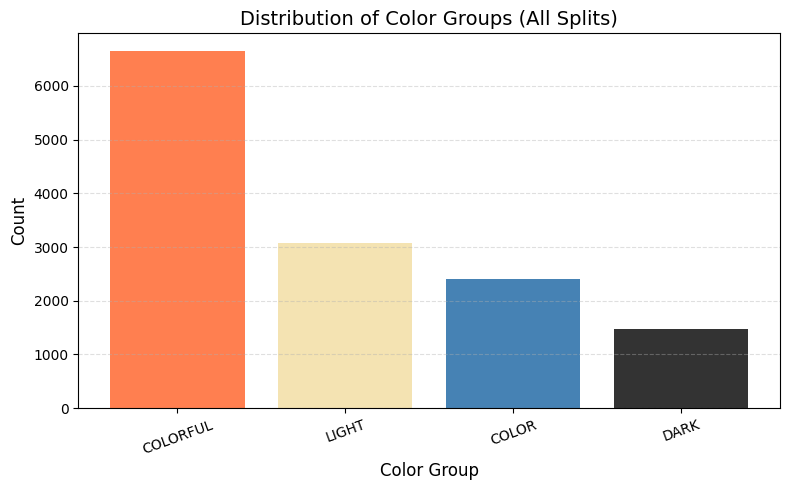

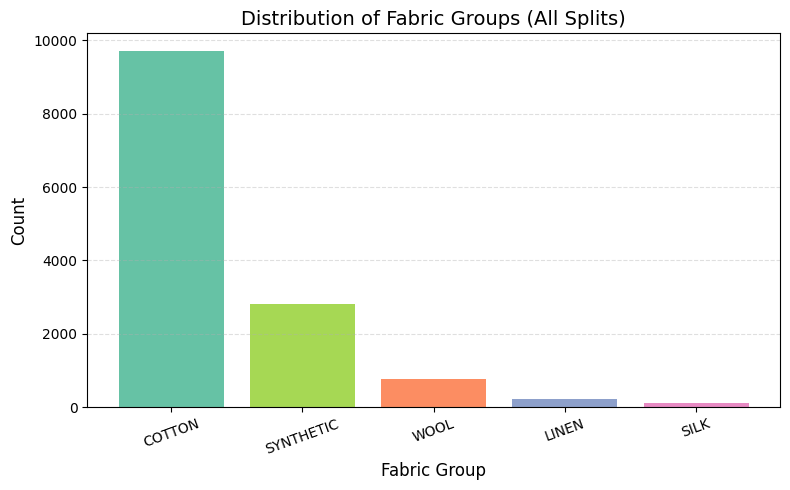

In [10]:
# Cell 1 — Load wash_labels.csv and visualize label distributions

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Core path (must match the master label-builder cell)
WASH_ROOT  = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV = os.path.join(WASH_ROOT, "wash_labels.csv")

print("Reading labels from:", LABELS_CSV)
assert os.path.exists(LABELS_CSV), f"wash_labels.csv not found at {LABELS_CSV}"

df_labels = pd.read_csv(LABELS_CSV)

print("\nHead of df_labels:")
print(df_labels.head())

print("\nSplit counts:")
print(df_labels["split"].value_counts())

print("\nColor group distribution:")
print(df_labels["color_group"].value_counts())

print("\nFabric group distribution:")
print(df_labels["fabric_group"].value_counts())

# --------- Helper: sorted bar plot ----------
def plot_sorted_bar(counts, title, xlabel, ylabel, color_map=None):
    """
    counts: pandas Series (index = class, values = counts)
    color_map: optional dict {class_name: color}
    """
    counts = counts.sort_values(ascending=False)
    classes = counts.index.tolist()
    values  = counts.values

    if color_map is not None:
        colors = [color_map.get(c, None) for c in classes]
    else:
        colors = None

    plt.figure(figsize=(8, 5))
    plt.bar(classes, values, color=colors)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


# Color palette for color_group classes (you can adjust)
color_group_palette = {
    "LIGHT":    "#f4e3b2",  # pale cream
    "DARK":     "#333333",  # dark gray/black
    "COLORFUL": "#ff7f50",  # coral
    "COLOR":    "#4682b4",  # steel blue
}

# Color palette for fabric_group classes
fabric_group_palette = {
    "COTTON":    "#66c2a5",
    "LINEN":     "#8da0cb",
    "WOOL":      "#fc8d62",
    "SILK":      "#e78ac3",
    "SYNTHETIC": "#a6d854",
}

# 1) Color group distribution (sorted)
plot_sorted_bar(
    df_labels["color_group"].value_counts(),
    title="Distribution of Color Groups (All Splits)",
    xlabel="Color Group",
    ylabel="Count",
    color_map=color_group_palette,
)

# 2) Fabric group distribution (sorted)
plot_sorted_bar(
    df_labels["fabric_group"].value_counts(),
    title="Distribution of Fabric Groups (All Splits)",
    xlabel="Fabric Group",
    ylabel="Count",
    color_map=fabric_group_palette,
)




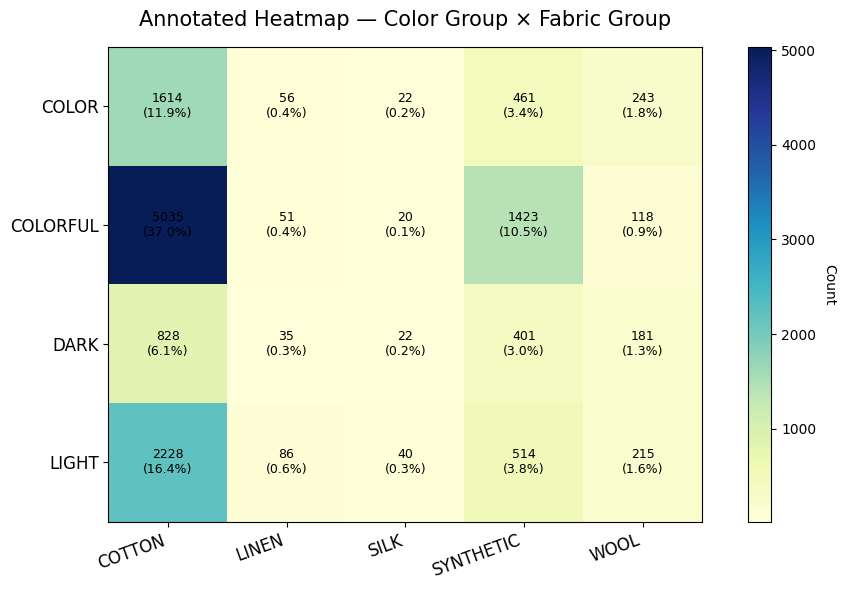

In [11]:
# === Cell: Professional Annotated Heatmap (Label Distribution) ===

import numpy as np
import matplotlib.pyplot as plt

pivot = (
    df_labels
    .groupby(["color_group", "fabric_group"])
    .size()
    .unstack(fill_value=0)
)

# Convert raw counts to percentages
pivot_percent = pivot / pivot.values.sum() * 100

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pivot.values, cmap="YlGnBu")

# Add colorbar
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# Add labels
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_yticks(np.arange(len(pivot.index)))

ax.set_xticklabels(pivot.columns, fontsize=12)
ax.set_yticklabels(pivot.index, fontsize=12)

plt.title("Annotated Heatmap — Color Group × Fabric Group", fontsize=15, pad=15)

# Rotate x-labels
plt.setp(ax.get_xticklabels(), rotation=20, ha="right")

# Annotate cells
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        count = pivot.values[i, j]
        percent = pivot_percent.values[i, j]
        ax.text(
            j, i,
            f"{count}\n({percent:.1f}%)",
            ha="center", va="center",
            fontsize=9,
            color="black" if percent < 50 else "white"
        )

plt.tight_layout()
plt.show()


In [12]:
# Cell 2 — Visualize random labeled images from each class

import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Make sure df_labels is still in memory (from previous cell)
assert "df_labels" in globals(), "df_labels is not defined. Run Cell 1 first."


def show_random_labeled_samples(df, title, n=8):
    """
    Show up to n random images from df with:
      - filename
      - article_id
      - color_group
      - fabric_group
    """
    if len(df) == 0:
        print(f"No samples to show for: {title}")
        return

    k = min(n, len(df))
    subset = df.sample(k, random_state=42)

    cols = 4
    rows = (k + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, (_, row) in enumerate(subset.iterrows()):
        img_path     = row["image_path"]
        article_id   = row["article_id"]
        color_group  = row["color_group"]
        fabric_group = row["fabric_group"]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"{Path(img_path).name}\n"
            f"{color_group} / {fabric_group}\n"
            f"article_id: {article_id}",
            fontsize=8
        )

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# ---- Visualize by color_group (train split only, for consistency) ----
for cg in ["LIGHT", "DARK", "COLORFUL", "COLOR"]:
    df_cg = df_labels[(df_labels["split"] == "train") & (df_labels["color_group"] == cg)]
    print(f"\n=== Showing samples for color_group = {cg} (train) ===")
    print("Count in train:", len(df_cg))
    show_random_labeled_samples(df_cg, f"TRAIN — {cg}", n=8)

# ---- Visualize by fabric_group (optional) ----
for fg in ["COTTON", "LINEN", "WOOL", "SILK", "SYNTHETIC"]:
    df_fg = df_labels[(df_labels["split"] == "train") & (df_labels["fabric_group"] == fg)]
    if len(df_fg) == 0:
        continue
    print(f"\n=== Showing samples for fabric_group = {fg} (train) ===")
    print("Count in train:", len(df_fg))
    show_random_labeled_samples(df_fg, f"TRAIN — {fg}", n=8)



=== Showing samples for color_group = LIGHT (train) ===
Count in train: 0
No samples to show for: TRAIN — LIGHT

=== Showing samples for color_group = DARK (train) ===
Count in train: 0
No samples to show for: TRAIN — DARK

=== Showing samples for color_group = COLORFUL (train) ===
Count in train: 0
No samples to show for: TRAIN — COLORFUL

=== Showing samples for color_group = COLOR (train) ===
Count in train: 0
No samples to show for: TRAIN — COLOR


In [13]:
# ============================================================
# Fast Post-processing Fixes for wash_labels.csv
# 1) Fix LIGHT vs COLORFUL for very light pastels
# 2) Remove multi-pack (multi-garment) articles using metadata
# ============================================================

import os
import re
import pandas as pd

# Paths (same as before)
WASH_ROOT    = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV   = os.path.join(WASH_ROOT, "wash_labels.csv")
ARTICLES_CSV = "/content/drive/MyDrive/hm/articles.csv"

print("Loading labels from:", LABELS_CSV)
df_labels = pd.read_csv(LABELS_CSV)

print("\nOriginal color_group counts:")
print(df_labels["color_group"].value_counts())

COLOR2IDX = {"LIGHT": 0, "DARK": 1, "COLORFUL": 2, "COLOR": 3}

# ------------------------------------------------------------
# (A) Fix LIGHT vs COLORFUL for very light, low-saturation items
# ------------------------------------------------------------
# Logic:
#   - Currently labeled COLORFUL
#   - Very light (v >= 0.75)
#   - Not strongly saturated (s <= 0.65)
#
# Works both for plain and striped items.

mask_colorful = (df_labels["color_group"] == "COLORFUL")
mask_lightish = (df_labels["v"] >= 0.75) & (df_labels["s"] <= 0.65)

mask_to_light = mask_colorful & mask_lightish

n_to_light = mask_to_light.sum()
print(f"\nRelabeling {n_to_light} samples from COLORFUL → LIGHT "
      f"(v >= 0.75 and s <= 0.65).")

df_labels.loc[mask_to_light, "color_group"] = "LIGHT"

# Recompute numeric color_label
df_labels["color_label"] = df_labels["color_group"].map(COLOR2IDX)

print("\nColor_group counts AFTER LIGHT/COLORFUL fix:")
print(df_labels["color_group"].value_counts())

# ------------------------------------------------------------
# (B) Remove multi-pack / multi-garment articles using metadata
# ------------------------------------------------------------
print("\nLoading articles.csv to detect multi-pack items ...")
articles = pd.read_csv(
    ARTICLES_CSV,
    dtype={"article_id": str},
    low_memory=False
)

# Clean to lower-case strings
for col in ["prod_name", "detail_desc"]:
    if col in articles.columns:
        articles[col] = articles[col].astype(str).str.lower()
    else:
        articles[col] = ""

# Heuristic: any mention of "pack" (2-pack, 3-pack, multipack, etc.)
articles["is_pack"] = (
    articles["prod_name"].str.contains("pack", na=False) |
    articles["detail_desc"].str.contains("pack", na=False)
)

pack_ids = set(articles.loc[articles["is_pack"], "article_id"])

mask_pack = df_labels["article_id"].astype(str).isin(pack_ids)
n_pack = mask_pack.sum()
print(f"\nDetected {n_pack} labeled rows belonging to multi-pack articles.")

# Drop them from df_labels
df_labels_clean = df_labels[~mask_pack].reset_index(drop=True)

print("\nFinal color_group counts AFTER removing multi-pack rows:")
print(df_labels_clean["color_group"].value_counts())

print("\nRemaining rows:", len(df_labels_clean))

# ------------------------------------------------------------
# Save back to CSV
# ------------------------------------------------------------
df_labels_clean.to_csv(LABELS_CSV, index=False)
print("\n Saved cleaned labels back to:", LABELS_CSV)


Loading labels from: /content/drive/MyDrive/wash_ai_project/wash_labels.csv

Original color_group counts:
color_group
COLORFUL    6647
LIGHT       3083
COLOR       2396
DARK        1467
Name: count, dtype: int64

Relabeling 2793 samples from COLORFUL → LIGHT (v >= 0.75 and s <= 0.65).

Color_group counts AFTER LIGHT/COLORFUL fix:
color_group
LIGHT       5876
COLORFUL    3854
COLOR       2396
DARK        1467
Name: count, dtype: int64

Loading articles.csv to detect multi-pack items ...

Detected 0 labeled rows belonging to multi-pack articles.

Final color_group counts AFTER removing multi-pack rows:
color_group
LIGHT       5876
COLORFUL    3854
COLOR       2396
DARK        1467
Name: count, dtype: int64

Remaining rows: 13593

 Saved cleaned labels back to: /content/drive/MyDrive/wash_ai_project/wash_labels.csv


In [14]:
# ============================================================
# Recompute color_group for plain garments (pattern_flag = 0)
#  - Patterned items stay COLORFUL
#  - Plain items → DARK / LIGHT / COLOR only
# ============================================================

import os
import pandas as pd

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")

print("Loading labels from:", LABELS_CSV)
df_labels = pd.read_csv(LABELS_CSV)

print("\nOriginal color_group counts:")
print(df_labels["color_group"].value_counts())

COLOR2IDX = {"LIGHT": 0, "DARK": 1, "COLORFUL": 2, "COLOR": 3}

# -----------------------------
# Thresholds (you can tune)
# -----------------------------
THRESH_DARK_V   = 0.55   # v ≤ 0.55 → DARK  (plain)
THRESH_LIGHT_V  = 0.75   # v ≥ 0.75 and s ≤ 0.65 → LIGHT
THRESH_LIGHT_S  = 0.65

# Masks
mask_pattern = (df_labels["pattern_flag"] == 1)
mask_plain   = (df_labels["pattern_flag"] == 0)

v = df_labels["v"]
s = df_labels["s"]

plain_dark  = mask_plain & (v <= THRESH_DARK_V)
plain_light = mask_plain & (v >= THRESH_LIGHT_V) & (s <= THRESH_LIGHT_S)
plain_color = mask_plain & ~(plain_dark | plain_light)

# 1) Patterned → COLORFUL
df_labels.loc[mask_pattern, "color_group"] = "COLORFUL"

# 2) Plain DARK / LIGHT / COLOR
df_labels.loc[plain_dark,  "color_group"] = "DARK"
df_labels.loc[plain_light, "color_group"] = "LIGHT"
df_labels.loc[plain_color, "color_group"] = "COLOR"

# Recompute numeric label
df_labels["color_label"] = df_labels["color_group"].map(COLOR2IDX)

print("\nUpdated color_group counts:")
print(df_labels["color_group"].value_counts())

# Save back
df_labels.to_csv(LABELS_CSV, index=False)
print("\n Saved updated labels to:", LABELS_CSV)


Loading labels from: /content/drive/MyDrive/wash_ai_project/wash_labels.csv

Original color_group counts:
color_group
LIGHT       5876
COLORFUL    3854
COLOR       2396
DARK        1467
Name: count, dtype: int64

Updated color_group counts:
color_group
COLORFUL    6273
DARK        2816
LIGHT       2809
COLOR       1695
Name: count, dtype: int64

 Saved updated labels to: /content/drive/MyDrive/wash_ai_project/wash_labels.csv


Loaded 13593 rows from wash_labels.csv
Columns: ['image_path', 'split', 'article_id', 'color_group', 'fabric_group', 'color_label', 'fabric_label', 'pattern_flag', 'h', 's', 'v', 'wash_temp_c', 'wash_cycle', 'spin_rpm', 'wash_notes', 'wash_cycle_label']

=== LIGHT — available samples: 2809 ===


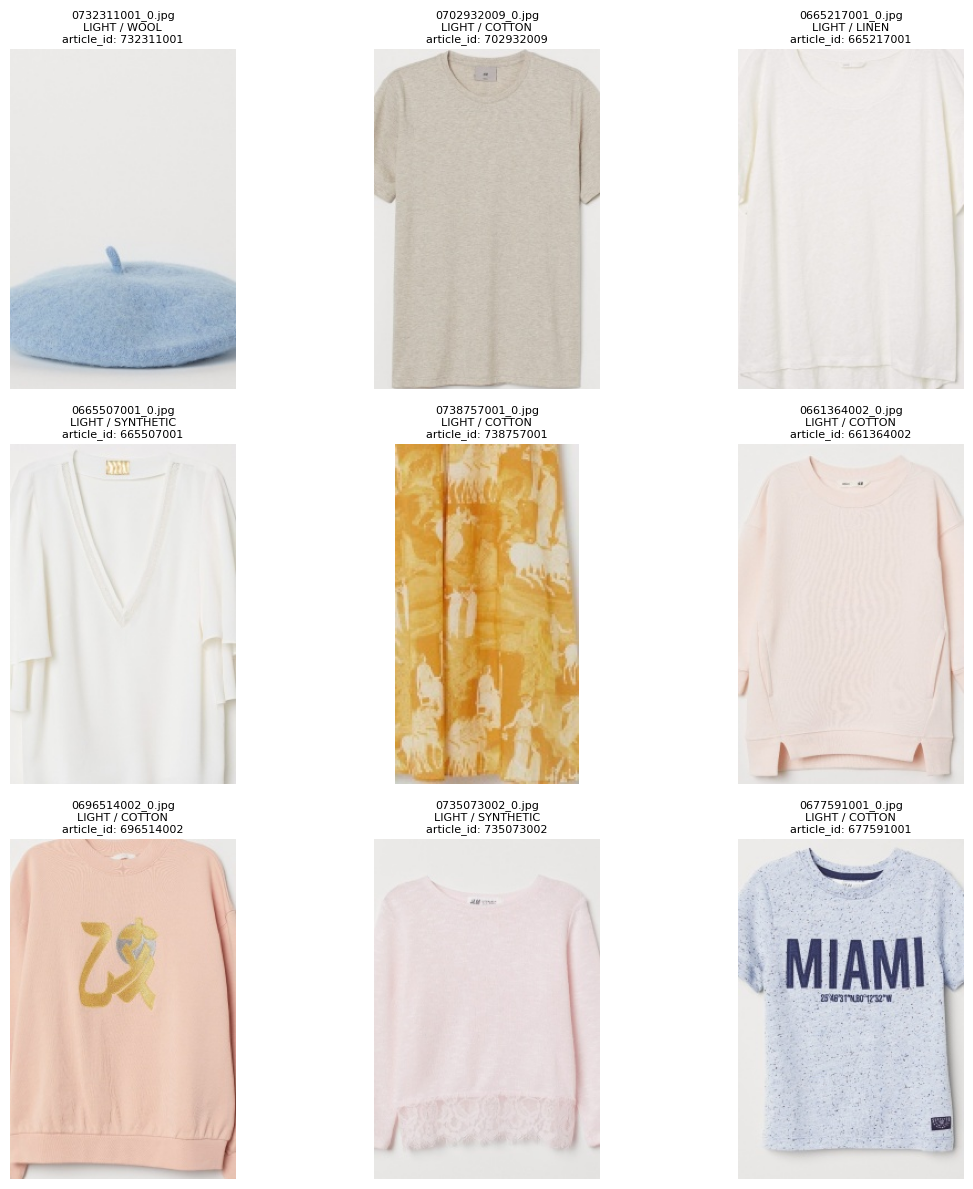


=== DARK — available samples: 2816 ===


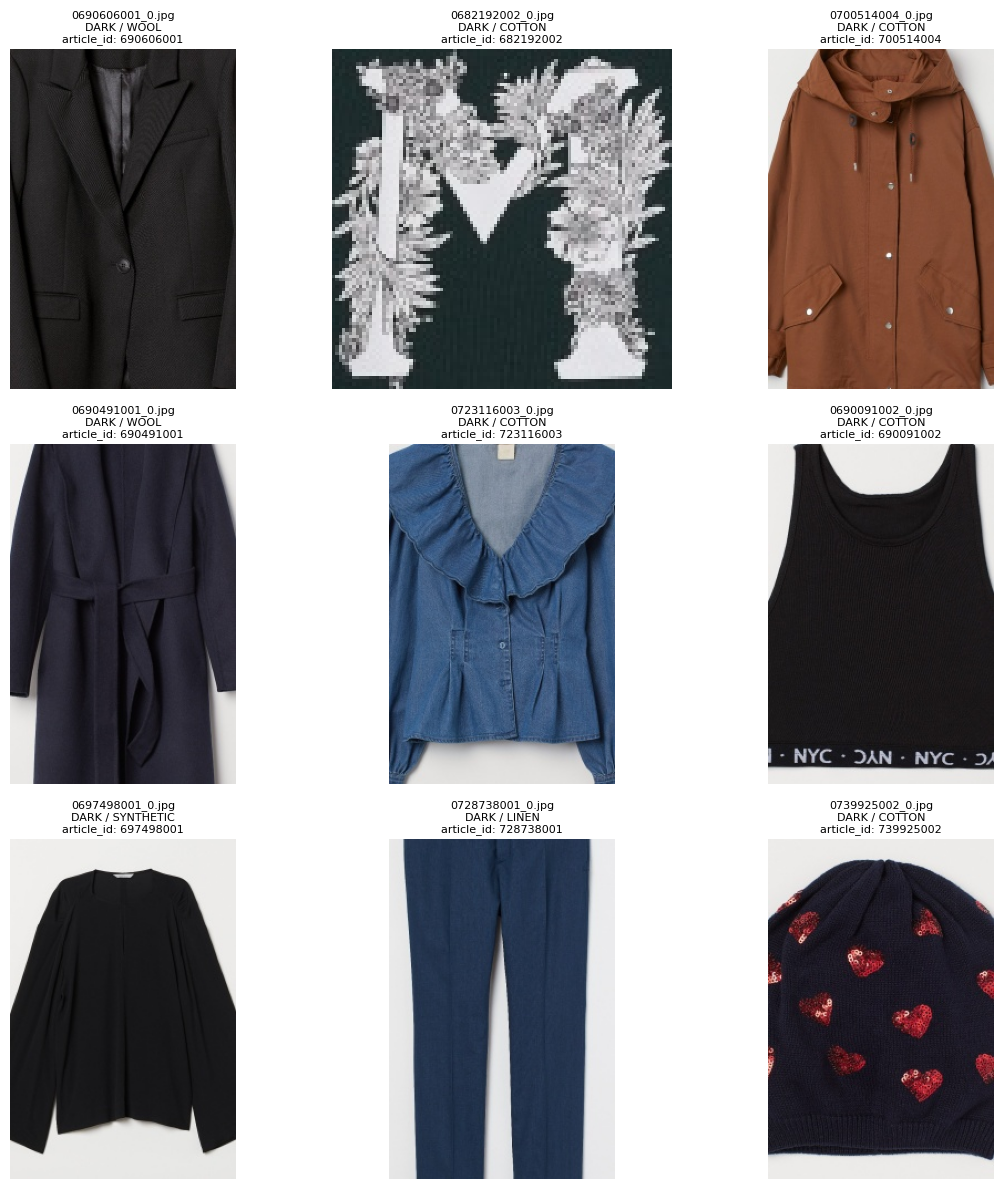


=== COLOR — available samples: 1695 ===


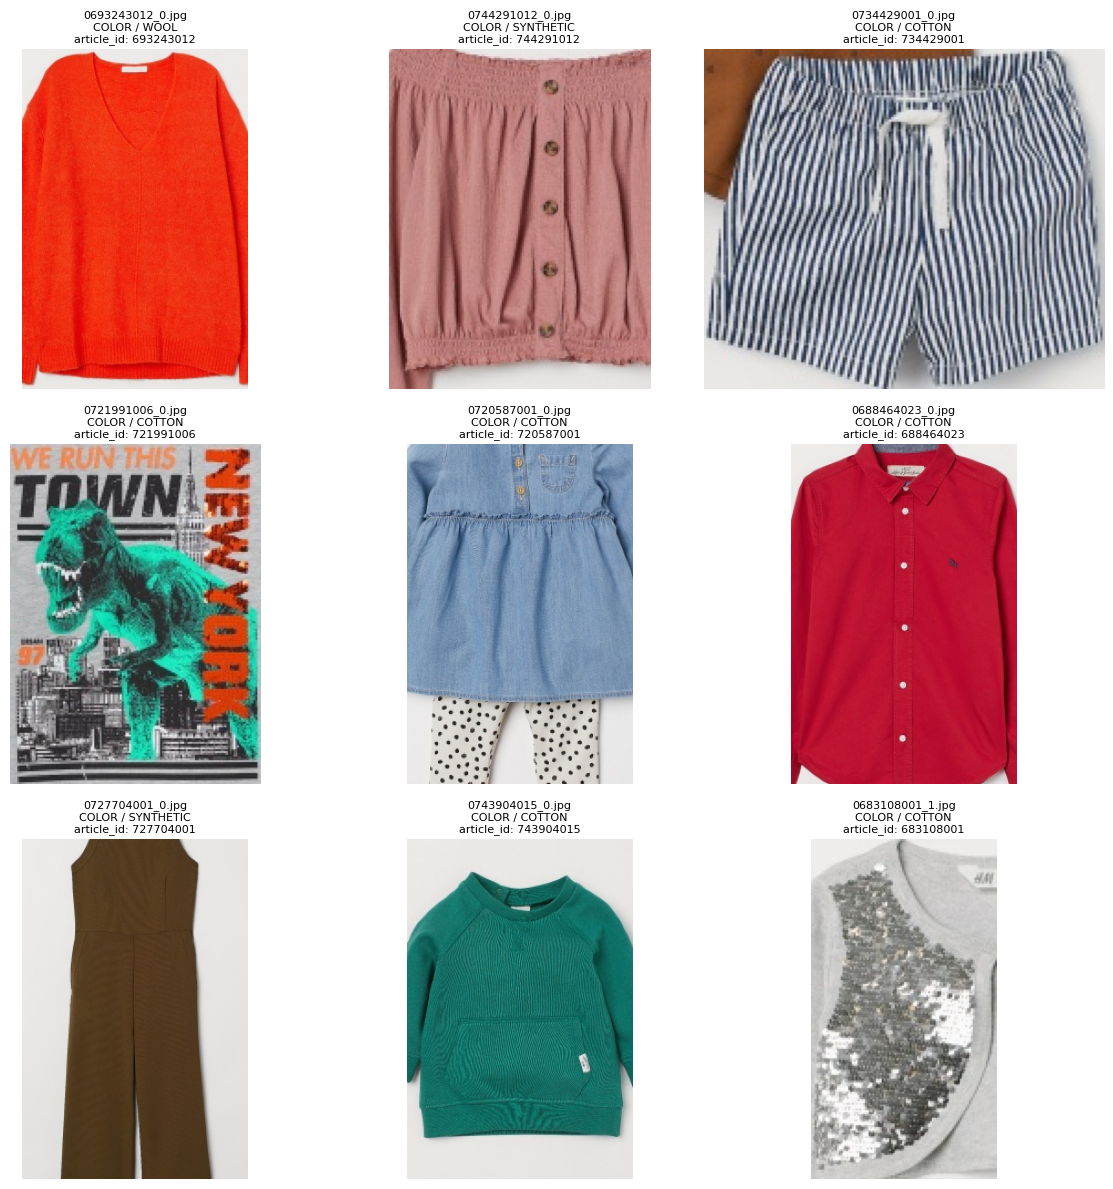


=== COLORFUL — available samples: 6273 ===


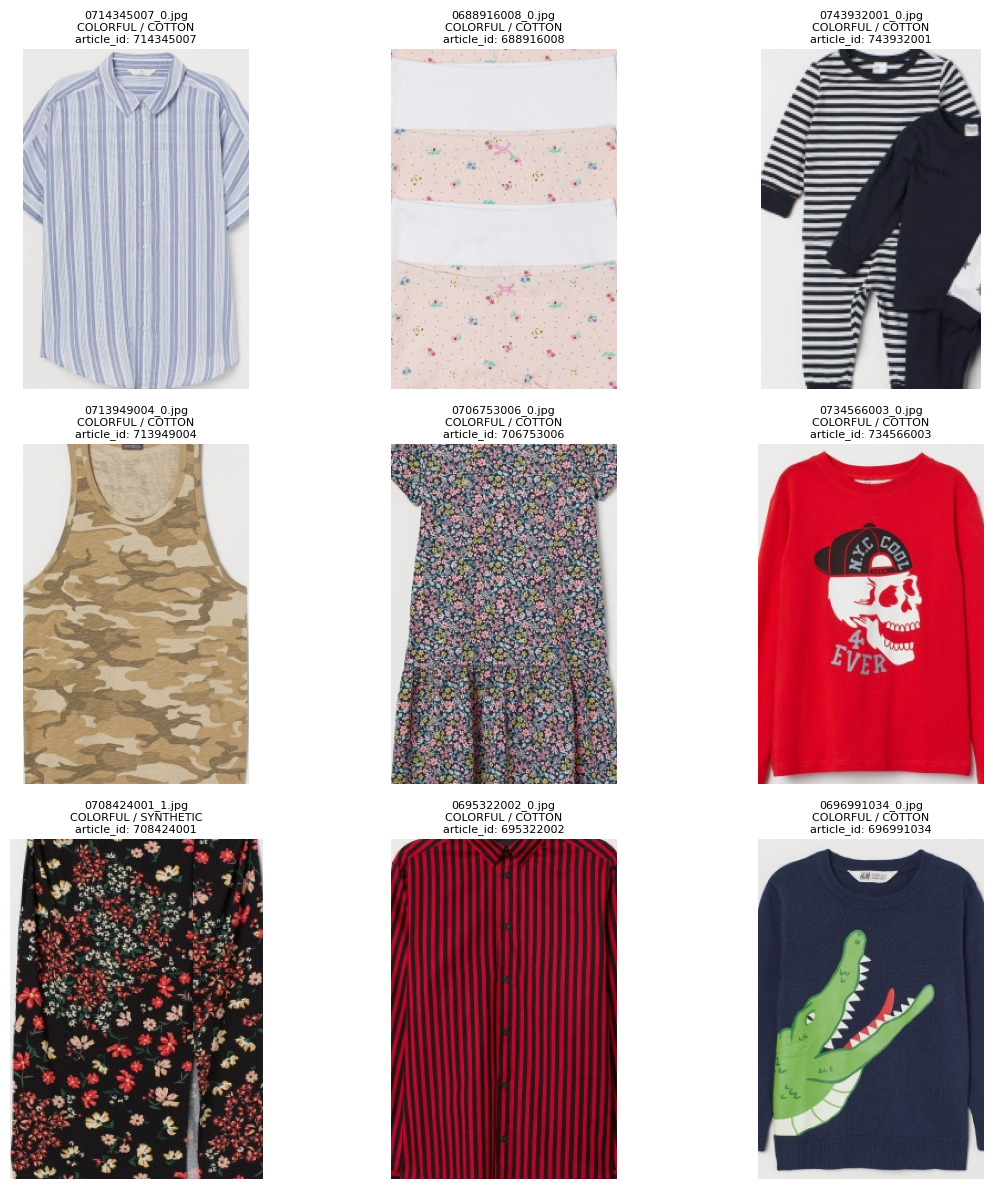

In [19]:
# ============================================================
# Visualization Cell — Show labeled images by COLOR GROUP
# ============================================================

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- Load labels ---
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")

df_labels = pd.read_csv(LABELS_CSV)
print("Loaded", len(df_labels), "rows from wash_labels.csv")
print("Columns:", list(df_labels.columns))

# Sanity check
assert "image_path"   in df_labels.columns, "image_path column missing"
assert "color_group"  in df_labels.columns, "color_group column missing"
assert "fabric_group" in df_labels.columns, "fabric_group column missing"

# --- Helper: open image safely ---
def safe_open(path):
    try:
        return Image.open(path).convert("RGB")
    except Exception as e:
        print(f"[WARN] Could not open {path}: {e}")
        return None

# --- Helper: show N random samples for a given color_group ---
def show_samples_for_group(color_group, n=9):
    subset = df_labels[df_labels["color_group"] == color_group]
    count = len(subset)
    print(f"\n=== {color_group} — available samples: {count} ===")

    if count == 0:
        print("No samples for this group.")
        return

    k = min(n, count)
    subset = subset.sample(k, random_state=42)

    cols = 3
    rows = (k + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, row in enumerate(subset.itertuples(), 1):
        img_path     = row.image_path
        color_g      = row.color_group
        fabric_g     = row.fabric_group
        article_id   = getattr(row, "article_id", "N/A")

        img = safe_open(img_path)
        if img is None:
            continue

        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"{os.path.basename(img_path)}\n"
            f"{color_g} / {fabric_g}\n"
            f"article_id: {article_id}",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()


# --- Show images for each color group ---
for cg in ["LIGHT", "DARK", "COLOR", "COLORFUL"]:
    show_samples_for_group(cg, n=9)


In [20]:
# ============================================================
# Cell — Add Washing Program Recommendation to wash_labels.csv
# ============================================================

import os
import pandas as pd

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")

df = pd.read_csv(LABELS_CSV)
print("Loaded labels:", len(df))
print("Columns:", list(df.columns))

assert "color_group"  in df.columns
assert "fabric_group" in df.columns

def assign_wash_program(color_group: str, fabric_group: str):
    """
    Rule-based washing program based on (color_group, fabric_group).
    Returns: (temp_c, cycle, spin_rpm, notes)
    """

    cg = str(color_group).upper()
    fg = str(fabric_group).upper()

    # --- Defaults (safe, gentle) ---
    temp_c   = 30
    cycle    = "normal"
    spin_rpm = 800
    notes    = []

    # --- Fabric-driven rules ---
    if fg == "WOOL":
        temp_c   = 20
        cycle    = "wool/delicate"
        spin_rpm = 600
        notes.append("Use wool detergent if possible.")
        notes.append("Do not tumble dry.")
    elif fg == "SILK":
        temp_c   = 20
        cycle    = "delicate/hand-wash"
        spin_rpm = 400
        notes.append("Use mild detergent.")
        notes.append("Place in laundry bag.")
    elif fg == "LINEN":
        temp_c   = 30
        cycle    = "normal/delicate"
        spin_rpm = 800
        notes.append("Avoid high heat to reduce shrinkage.")
    elif fg == "COTTON":
        temp_c   = 30
        cycle    = "normal"
        spin_rpm = 1000
        notes.append("Turn inside out if printed or dark.")
    elif fg == "SYNTHETIC":
        temp_c   = 30
        cycle    = "synthetic/easy-care"
        spin_rpm = 1000
        notes.append("Good for anti-crease program if available.")

    # --- Color-driven adjustments ---
    if cg == "DARK":
        temp_c = min(temp_c, 30)      # never above 30 for darks
        spin_rpm = min(spin_rpm, 800)
        notes.append("Wash with similar dark colors.")
        notes.append("Use color-care detergent.")
    elif cg == "LIGHT":
        # light & delicate already handled by fabric
        if fg == "COTTON" or fg == "LINEN" or fg == "SYNTHETIC":
            temp_c = max(temp_c, 30)  # 30–40 OK, but we keep 30 by default
        notes.append("Wash with light colors.")
    elif cg == "COLORFUL":
        temp_c = min(temp_c, 30)
        spin_rpm = min(spin_rpm, 900)
        notes.append("Wash with similar bright colors.")
        notes.append("Do not overload the drum.")
    elif cg == "COLOR":
        # mid-tone colors, slightly more flexible
        temp_c = min(max(temp_c, 30), 40)
        notes.append("Wash with similar colors.")

    # remove duplicates in notes
    notes = list(dict.fromkeys(notes))

    return temp_c, cycle, spin_rpm, " ".join(notes)


# Apply to all rows
temps   = []
cycles  = []
spins   = []
notes_l = []

for row in df.itertuples():
    t, c, s, nt = assign_wash_program(row.color_group, row.fabric_group)
    temps.append(t)
    cycles.append(c)
    spins.append(s)
    notes_l.append(nt)

df["wash_temp_c"] = temps
df["wash_cycle"]  = cycles
df["spin_rpm"]    = spins
df["wash_notes"]  = notes_l

print("\nSample rows with washing program:")
print(
    df[[
        "image_path",
        "color_group",
        "fabric_group",
        "wash_temp_c",
        "wash_cycle",
        "spin_rpm",
        "wash_notes"
    ]].head()
)

df.to_csv(LABELS_CSV, index=False)
print("\n Saved updated wash_labels.csv with washing program columns.")


Loaded labels: 13593
Columns: ['image_path', 'split', 'article_id', 'color_group', 'fabric_group', 'color_label', 'fabric_label', 'pattern_flag', 'h', 's', 'v', 'wash_temp_c', 'wash_cycle', 'spin_rpm', 'wash_notes', 'wash_cycle_label']

Sample rows with washing program:
                                          image_path color_group fabric_group  \
0  /content/drive/MyDrive/wash_ai_outputs/crops_b...        DARK    SYNTHETIC   
1  /content/drive/MyDrive/wash_ai_outputs/crops_b...    COLORFUL       COTTON   
2  /content/drive/MyDrive/wash_ai_outputs/crops_b...    COLORFUL    SYNTHETIC   
3  /content/drive/MyDrive/wash_ai_outputs/crops_b...    COLORFUL    SYNTHETIC   
4  /content/drive/MyDrive/wash_ai_outputs/crops_b...        DARK    SYNTHETIC   

   wash_temp_c           wash_cycle  spin_rpm  \
0           30  synthetic/easy-care       800   
1           30               normal       900   
2           30  synthetic/easy-care       900   
3           30  synthetic/easy-care       900 

In [21]:
# ============================================================
# Cell 1 — Encode wash_cycle as an integer label
# ============================================================

import os
import pandas as pd

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")

df = pd.read_csv(LABELS_CSV)
print("Loaded:", len(df), "rows")
print("Columns:", list(df.columns))

assert "wash_cycle" in df.columns, "wash_cycle not found — run the washing-program cell first."

# Get unique cycles
unique_cycles = sorted(df["wash_cycle"].astype(str).unique())
print("\nUnique wash cycles:")
for i, c in enumerate(unique_cycles):
    print(f"{i}: {c}")

# Build mapping
WASHCYCLE2IDX = {c: i for i, c in enumerate(unique_cycles)}
IDX2WASHCYCLE = {i: c for c, i in WASHCYCLE2IDX.items()}

# Encode
df["wash_cycle_label"] = df["wash_cycle"].astype(str).map(WASHCYCLE2IDX).astype(int)

print("\nDistribution of wash_cycle_label:")
print(df["wash_cycle_label"].value_counts())

df.to_csv(LABELS_CSV, index=False)
print("\n Saved updated CSV with wash_cycle_label to:", LABELS_CSV)
print("\nMapping WASHCYCLE2IDX:", WASHCYCLE2IDX)


Loaded: 13593 rows
Columns: ['image_path', 'split', 'article_id', 'color_group', 'fabric_group', 'color_label', 'fabric_label', 'pattern_flag', 'h', 's', 'v', 'wash_temp_c', 'wash_cycle', 'spin_rpm', 'wash_notes', 'wash_cycle_label']

Unique wash cycles:
0: delicate/hand-wash
1: normal
2: normal/delicate
3: synthetic/easy-care
4: wool/delicate

Distribution of wash_cycle_label:
wash_cycle_label
1    9705
3    2799
4     757
2     228
0     104
Name: count, dtype: int64

 Saved updated CSV with wash_cycle_label to: /content/drive/MyDrive/wash_ai_project/wash_labels.csv

Mapping WASHCYCLE2IDX: {'delicate/hand-wash': 0, 'normal': 1, 'normal/delicate': 2, 'synthetic/easy-care': 3, 'wool/delicate': 4}


In [23]:
# ============================================================
# Cell 2 — Multi-task ConvNeXt: COLOR + FABRIC + WASH_CYCLE
# ============================================================

import os
import time
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# ------------------------
# 0) Config & data loading
# ------------------------

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df_labels = pd.read_csv(LABELS_CSV)
print("Loaded labels:", len(df_labels))

required_cols = [
    "image_path",
    "split",
    "color_label",
    "fabric_label",
    "wash_cycle_label",
    "color_group",
    "fabric_group",
    "wash_cycle",
]
for c in required_cols:
    assert c in df_labels.columns, f"Missing column: {c}"

df_labels["color_label"]       = df_labels["color_label"].astype(int)
df_labels["fabric_label"]      = df_labels["fabric_label"].astype(int)
df_labels["wash_cycle_label"]  = df_labels["wash_cycle_label"].astype(int)

num_color_classes  = df_labels["color_label"].nunique()
num_fabric_classes = df_labels["fabric_label"].nunique()
num_wash_classes   = df_labels["wash_cycle_label"].nunique()

print(f"Num COLOR classes     : {num_color_classes}")
print(f"Num FABRIC classes    : {num_fabric_classes}")
print(f"Num WASH_CYCLE classes: {num_wash_classes}")

# ---------------------------------------------------
# FIX: ensure we actually have a non-empty TRAIN split
# ---------------------------------------------------
if "split" not in df_labels.columns:
    # Fallback: everything is train if split is missing
    print("WARNING: 'split' column missing — marking all rows as TRAIN.")
    df_labels["split"] = "train"
else:
    n_train = (df_labels["split"] == "train").sum()
    n_val   = (df_labels["split"] == "val").sum()
    print(f"Current split counts (before fix): train={n_train}, val={n_val}")

    if n_train == 0:
        # Your error case: only VAL rows remained after cleaning.
        print("WARNING: no TRAIN rows found — creating a new 80/20 TRAIN/VAL split.")

        # Shuffle and create new split
        df_labels = df_labels.sample(frac=1.0, random_state=42).reset_index(drop=True)
        n_total = len(df_labels)
        n_train_new = int(0.8 * n_total)
        n_val_new   = n_total - n_train_new

        df_labels.loc[:n_train_new - 1, "split"] = "train"
        df_labels.loc[n_train_new:,     "split"] = "val"

        # Save back so all later cells (evaluation, demo, ...) see the same split
        df_labels.to_csv(LABELS_CSV, index=False)
        print(f"New split created and saved: train={n_train_new}, val={n_val_new}")

# ------------------------
# 1) Dataset / transforms
# ------------------------

IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class WashMultiTaskDataset(Dataset):
    """
    Returns:
      X  -> image
      y_color       -> int in [0, num_color_classes-1]
      y_fabric      -> int in [0, num_fabric_classes-1]
      y_wash_cycle  -> int in [0, num_wash_classes-1]
    """
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        y_color      = int(row["color_label"])
        y_fabric     = int(row["fabric_label"])
        y_wash_cycle = int(row["wash_cycle_label"])

        return (
            img,
            torch.tensor(y_color, dtype=torch.long),
            torch.tensor(y_fabric, dtype=torch.long),
            torch.tensor(y_wash_cycle, dtype=torch.long),
        )

df_train = df_labels[df_labels["split"] == "train"].copy()
df_val   = df_labels[df_labels["split"] == "val"].copy()

print("Train rows:", len(df_train))
print("Val rows  :", len(df_val))

train_dataset = WashMultiTaskDataset(df_train, transform=train_transform)
val_dataset   = WashMultiTaskDataset(df_val,   transform=val_transform)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# ------------------------
# 2) Model: ConvNeXt-Tiny with 3 heads
# ------------------------

class WashMultiTaskConvNeXt(nn.Module):
    def __init__(self,
                 backbone_name="convnext_tiny",
                 num_color=4,
                 num_fabric=5,
                 num_wash=4):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes=0,
            global_pool="avg"
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)  # [B, feat_dim]
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name="convnext_tiny",
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

# ------------------------
# 3) Losses, optimizer, scheduler
# ------------------------

criterion_color      = nn.CrossEntropyLoss()
criterion_fabric     = nn.CrossEntropyLoss()
criterion_wash_cycle = nn.CrossEntropyLoss()

# You can weight them if you want certain tasks more important
w_color      = 0.4
w_fabric     = 0.3
w_wash_cycle = 0.3

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

NUM_EPOCHS = 16
best_val_wash_acc = 0.0
ckpt_path = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

# ------------------------
# 4) Training & validation
# ------------------------

def run_epoch(loader, model, optimizer=None):
    """
    If optimizer is None → evaluation mode.
    Returns:
      avg_loss,
      color_acc,
      fabric_acc,
      wash_cycle_acc
    """
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    total_samples = 0

    correct_color = 0
    correct_fabric = 0
    correct_wash = 0

    for batch in tqdm(loader, leave=False):
        imgs, y_color, y_fabric, y_wash = batch
        imgs    = imgs.to(device, non_blocking=True)
        y_color = y_color.to(device, non_blocking=True)
        y_fabric = y_fabric.to(device, non_blocking=True)
        y_wash  = y_wash.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad()

        logits_color, logits_fabric, logits_wash = model(imgs)

        loss_color      = criterion_color(logits_color, y_color)
        loss_fabric     = criterion_fabric(logits_fabric, y_fabric)
        loss_wash_cycle = criterion_wash_cycle(logits_wash, y_wash)

        loss = (
            w_color      * loss_color +
            w_fabric     * loss_fabric +
            w_wash_cycle * loss_wash_cycle
        )

        if is_train:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss    += loss.item() * bs
        total_samples += bs

        preds_color  = logits_color.argmax(dim=1)
        preds_fabric = logits_fabric.argmax(dim=1)
        preds_wash   = logits_wash.argmax(dim=1)

        correct_color  += (preds_color  == y_color).sum().item()
        correct_fabric += (preds_fabric == y_fabric).sum().item()
        correct_wash   += (preds_wash   == y_wash).sum().item()

    avg_loss = total_loss / max(1, total_samples)
    color_acc  = correct_color  / max(1, total_samples)
    fabric_acc = correct_fabric / max(1, total_samples)
    wash_acc   = correct_wash   / max(1, total_samples)

    return avg_loss, color_acc, fabric_acc, wash_acc


print("\n===============================")
print("Starting multi-task training ...")
print("===============================\n")

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    train_loss, train_c_acc, train_f_acc, train_w_acc = run_epoch(
        train_loader, model, optimizer
    )

    val_loss, val_c_acc, val_f_acc, val_w_acc = run_epoch(
        val_loader, model, optimizer=None
    )

    scheduler.step()

    elapsed = (time.time() - t0) / 60.0

    print(
        f"[Epoch {epoch:02d}] "
        f"TrainLoss={train_loss:.4f} | "
        f"TrainColorAcc={train_c_acc*100:5.2f}% | "
        f"TrainFabricAcc={train_f_acc*100:5.2f}% | "
        f"TrainWashAcc={train_w_acc*100:5.2f}% || "
        f"ValLoss={val_loss:.4f} | "
        f"ValColorAcc={val_c_acc*100:5.2f}% | "
        f"ValFabricAcc={val_f_acc*100:5.2f}% | "
        f"ValWashAcc={val_w_acc*100:5.2f}% | "
        f"Time={elapsed:.1f} min"
    )

    # Save best based on wash-cycle accuracy (main demo target)
    if val_w_acc > best_val_wash_acc:
        best_val_wash_acc = val_w_acc
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ✓ New BEST (ValWashAcc={val_w_acc*100:5.2f}%) — saved to {ckpt_path}")

print("\nTraining finished.")
print(f"Best validation wash-cycle accuracy: {best_val_wash_acc*100:.2f}%")
print("Best model checkpoint:", ckpt_path)


Using device: cuda
Loaded labels: 13593
Num COLOR classes     : 4
Num FABRIC classes    : 5
Num WASH_CYCLE classes: 5
Current split counts (before fix): train=0, val=13593
New split created and saved: train=10874, val=2719
Train rows: 10874
Val rows  : 2719


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Starting multi-task training ...



  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^can only test a child process
AssertionError: 


[Epoch 01] TrainLoss=0.8201 | TrainColorAcc=64.82% | TrainFabricAcc=70.53% | TrainWashAcc=70.79% || ValLoss=0.7259 | ValColorAcc=75.40% | ValFabricAcc=72.27% | ValWashAcc=72.16% | Time=4.4 min
  ✓ New BEST (ValWashAcc=72.16%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 02] TrainLoss=0.6788 | TrainColorAcc=77.13% | TrainFabricAcc=72.24% | TrainWashAcc=72.18% || ValLoss=0.6592 | ValColorAcc=78.60% | ValFabricAcc=72.23% | ValWashAcc=72.31% | Time=4.3 min
  ✓ New BEST (ValWashAcc=72.31%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 03] TrainLoss=0.6237 | TrainColorAcc=79.51% | TrainFabricAcc=73.99% | TrainWashAcc=74.05% || ValLoss=0.6289 | ValColorAcc=80.58% | ValFabricAcc=74.99% | ValWashAcc=75.10% | Time=4.3 min
  ✓ New BEST (ValWashAcc=75.10%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
can only test a child processAssertionError: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/85 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^    if w.is_alive():^
^^ ^  ^ ^^ ^ ^ ^^^^^^^^^^

[Epoch 04] TrainLoss=0.5791 | TrainColorAcc=81.91% | TrainFabricAcc=75.64% | TrainWashAcc=75.53% || ValLoss=0.5938 | ValColorAcc=83.30% | ValFabricAcc=75.36% | ValWashAcc=75.54% | Time=4.4 min
  ✓ New BEST (ValWashAcc=75.54%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 05] TrainLoss=0.5432 | TrainColorAcc=83.12% | TrainFabricAcc=76.99% | TrainWashAcc=76.94% || ValLoss=0.5790 | ValColorAcc=83.30% | ValFabricAcc=75.40% | ValWashAcc=75.54% | Time=4.3 min


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 06] TrainLoss=0.5026 | TrainColorAcc=84.64% | TrainFabricAcc=78.32% | TrainWashAcc=78.27% || ValLoss=0.5695 | ValColorAcc=80.99% | ValFabricAcc=78.19% | ValWashAcc=78.15% | Time=4.3 min
  ✓ New BEST (ValWashAcc=78.15%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f96ec3f27a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 07] TrainLoss=0.4536 | TrainColorAcc=86.46% | TrainFabricAcc=80.72% | TrainWashAcc=80.73% || ValLoss=0.5104 | ValColorAcc=85.33% | ValFabricAcc=78.96% | ValWashAcc=79.00% | Time=4.4 min
  ✓ New BEST (ValWashAcc=79.00%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 08] TrainLoss=0.4065 | TrainColorAcc=88.20% | TrainFabricAcc=82.32% | TrainWashAcc=82.44% || ValLoss=0.5072 | ValColorAcc=85.25% | ValFabricAcc=77.79% | ValWashAcc=77.60% | Time=4.2 min


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 09] TrainLoss=0.3469 | TrainColorAcc=90.13% | TrainFabricAcc=84.73% | TrainWashAcc=84.76% || ValLoss=0.5174 | ValColorAcc=83.74% | ValFabricAcc=79.70% | ValWashAcc=79.85% | Time=4.3 min
  ✓ New BEST (ValWashAcc=79.85%) — saved to /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

[Epoch 10] TrainLoss=0.3039 | TrainColorAcc=91.42% | TrainFabricAcc=86.90% | TrainWashAcc=86.82% || ValLoss=0.5188 | ValColorAcc=85.44% | ValFabricAcc=79.33% | ValWashAcc=79.44% | Time=4.3 min

Training finished.
Best validation wash-cycle accuracy: 79.85%
Best model checkpoint: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


Using device: cuda
Loaded labels: 13593
Validation rows: 2719
COLOR classes     : 4
FABRIC classes    : 5
WASH-CYCLE classes: 5

Color classes: [(0, 'LIGHT'), (1, 'DARK'), (2, 'COLORFUL'), (3, 'COLOR')]
Fabric classes: [(0, 'COTTON'), (1, 'LINEN'), (2, 'WOOL'), (3, 'SILK'), (4, 'SYNTHETIC')]
Wash-cycle classes: [(0, 'delicate/hand-wash'), (1, 'normal'), (2, 'normal/delicate'), (3, 'synthetic/easy-care'), (4, 'wool/delicate')]

Loaded best model checkpoint from: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]


================ VALIDATION ACCURACY ================
Color accuracy      : 83.74%
Fabric accuracy     : 79.70%
Wash-cycle accuracy : 79.85%


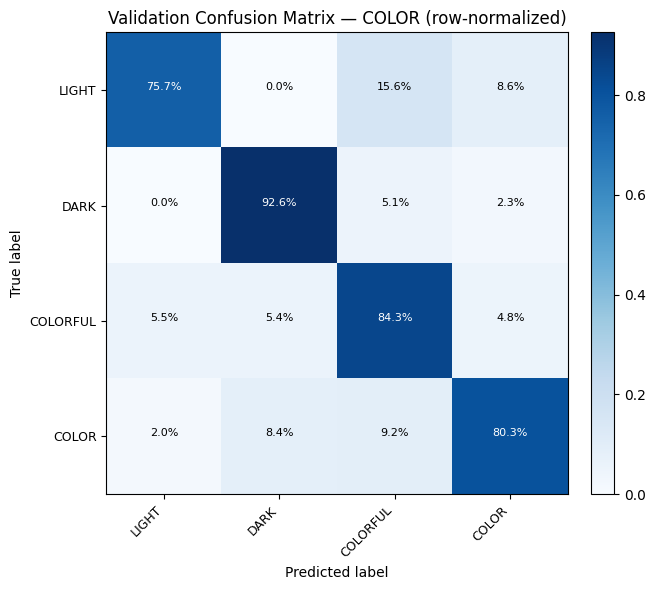

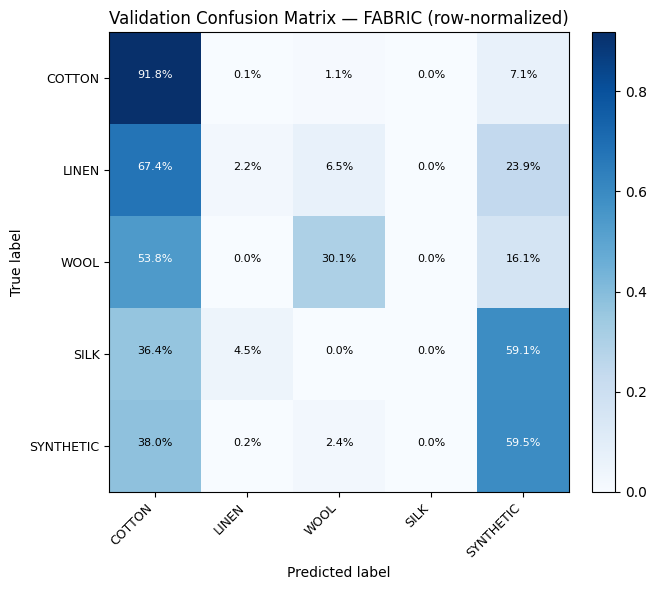

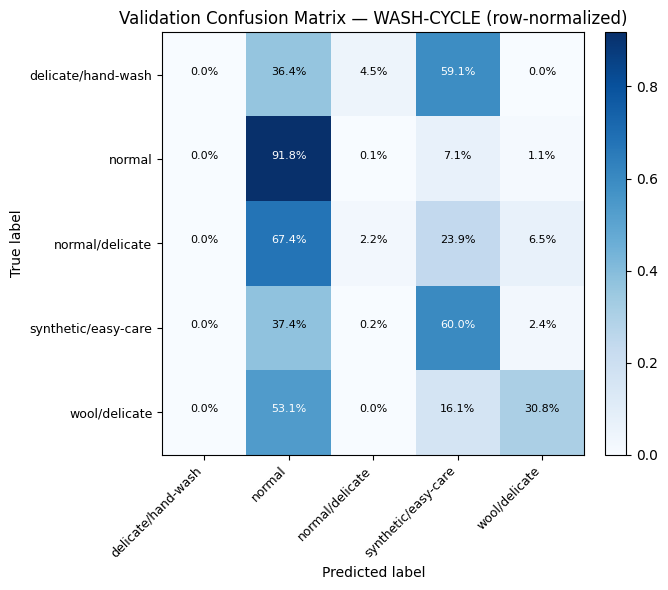


Showing sample predictions from the validation set:


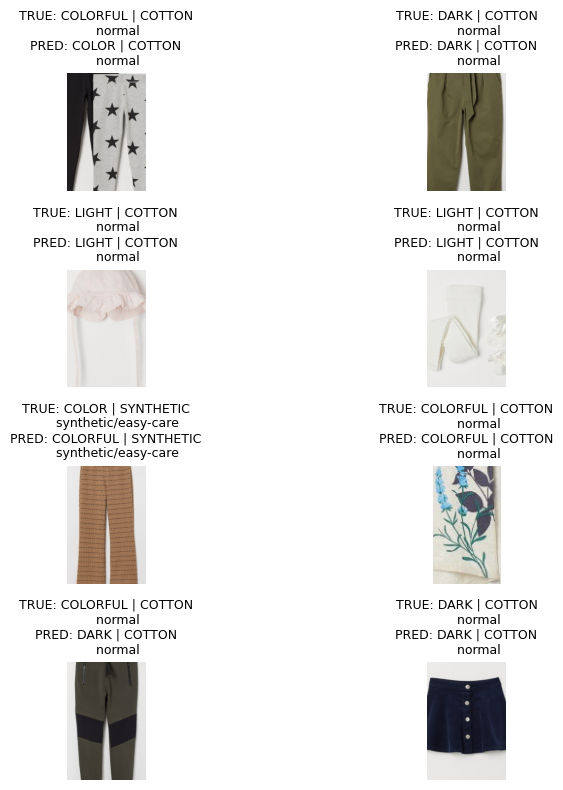

In [24]:
# ================================================================
# EVALUATION CELL — Best Model on Validation Set
# ---------------------------------------------------------------
# This cell:
#   • Loads the best saved checkpoint
#   • Evaluates COLOR / FABRIC / WASH-CYCLE accuracy on VAL set
#   • Computes row-normalized confusion matrices (percentages)
#   • Displays qualitative predictions on sample images
# ================================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import timm

# -----------------------------------------------------------
# 0) Paths, device setup, and label loading
# -----------------------------------------------------------
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

assert os.path.exists(LABELS_CSV), f"Labels CSV not found: {LABELS_CSV}"
assert os.path.exists(CKPT_PATH),  f"Checkpoint not found: {CKPT_PATH}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df_labels = pd.read_csv(LABELS_CSV)
print("Loaded labels:", len(df_labels))

# Use only VAL split for evaluation
df_val = df_labels[df_labels["split"] == "val"].copy()
print("Validation rows:", len(df_val))

# Ensure labels are integers
df_val["color_label"]      = df_val["color_label"].astype(int)
df_val["fabric_label"]     = df_val["fabric_label"].astype(int)
df_val["wash_cycle_label"] = df_val["wash_cycle_label"].astype(int)

# Class counts (global, consistent with training)
num_color_classes  = df_labels["color_label"].nunique()
num_fabric_classes = df_labels["fabric_label"].nunique()
num_wash_classes   = df_labels["wash_cycle_label"].nunique()

print(f"COLOR classes     : {num_color_classes}")
print(f"FABRIC classes    : {num_fabric_classes}")
print(f"WASH-CYCLE classes: {num_wash_classes}")

# Mappings for readable axis labels
color_map  = df_val.groupby("color_label")["color_group"].agg(lambda x: x.mode()[0]).to_dict()
fabric_map = df_val.groupby("fabric_label")["fabric_group"].agg(lambda x: x.mode()[0]).to_dict()
wash_map   = df_val.groupby("wash_cycle_label")["wash_cycle"].agg(lambda x: x.mode()[0]).to_dict()

color_names  = [color_map[i]  for i in sorted(color_map.keys())]
fabric_names = [fabric_map[i] for i in sorted(fabric_map.keys())]
wash_names   = [wash_map[i]   for i in sorted(wash_map.keys())]

print("\nColor classes:",  list(zip(sorted(color_map.keys()), color_names)))
print("Fabric classes:", list(zip(sorted(fabric_map.keys()), fabric_names)))
print("Wash-cycle classes:", list(zip(sorted(wash_map.keys()), wash_names)))

# -----------------------------------------------------------
# 1) Dataset + preprocessing transforms
# -----------------------------------------------------------
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class WashValDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return (
            img,
            torch.tensor(row["color_label"], dtype=torch.long),
            torch.tensor(row["fabric_label"], dtype=torch.long),
            torch.tensor(row["wash_cycle_label"], dtype=torch.long),
        )

val_dataset = WashValDataset(df_val, transform=val_transform)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# -----------------------------------------------------------
# 2) Model definition (same as training configuration)
# -----------------------------------------------------------
class WashMultiTaskConvNeXt(nn.Module):
    def __init__(self, backbone_name="convnext_tiny",
                 num_color=4, num_fabric=5, num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,     # weights loaded from checkpoint
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        return (
            self.head_color(feat),
            self.head_fabric(feat),
            self.head_wash_cycle(feat),
        )

model = WashMultiTaskConvNeXt(
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

# Load best checkpoint
state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("\nLoaded best model checkpoint from:", CKPT_PATH)

# -----------------------------------------------------------
# 3) Inference loop on VAL set
# -----------------------------------------------------------
all_y_color, all_p_color = [], []
all_y_fabric, all_p_fabric = [], []
all_y_wash, all_p_wash = [], []

with torch.no_grad():
    for imgs, y_color, y_fabric, y_wash in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        y_color  = y_color.to(device)
        y_fabric = y_fabric.to(device)
        y_wash   = y_wash.to(device)

        pred_color, pred_fabric, pred_wash = model(imgs)

        all_y_color.extend(y_color.cpu().numpy())
        all_p_color.extend(pred_color.argmax(dim=1).cpu().numpy())

        all_y_fabric.extend(y_fabric.cpu().numpy())
        all_p_fabric.extend(pred_fabric.argmax(dim=1).cpu().numpy())

        all_y_wash.extend(y_wash.cpu().numpy())
        all_p_wash.extend(pred_wash.argmax(dim=1).cpu().numpy())

# Overall accuracies
color_acc  = (np.array(all_y_color)  == np.array(all_p_color)).mean()
fabric_acc = (np.array(all_y_fabric) == np.array(all_p_fabric)).mean()
wash_acc   = (np.array(all_y_wash)   == np.array(all_p_wash)).mean()

print("\n================ VALIDATION ACCURACY ================")
print(f"Color accuracy      : {color_acc  * 100:5.2f}%")
print(f"Fabric accuracy     : {fabric_acc * 100:5.2f}%")
print(f"Wash-cycle accuracy : {wash_acc   * 100:5.2f}%")

# -----------------------------------------------------------
# 4) Confusion matrix plotting
# -----------------------------------------------------------
def plot_confusion_matrix(cm, classes, title, normalize=True):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    plt.figure(figsize=(7, 6))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title, fontsize=12)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right", fontsize=9)
    plt.yticks(tick_marks, classes, fontsize=9)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt = f"{cm[i, j] * 100:.1f}%" if normalize else str(cm[i, j])
        plt.text(j, i, txt,
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)

    plt.ylabel("True label", fontsize=10)
    plt.xlabel("Predicted label", fontsize=10)
    plt.tight_layout()
    plt.show()

# Confusion matrices
plot_confusion_matrix(
    confusion_matrix(all_y_color, all_p_color),
    color_names,
    "Validation Confusion Matrix — COLOR (row-normalized)",
)

plot_confusion_matrix(
    confusion_matrix(all_y_fabric, all_p_fabric),
    fabric_names,
    "Validation Confusion Matrix — FABRIC (row-normalized)",
)

plot_confusion_matrix(
    confusion_matrix(all_y_wash, all_p_wash),
    wash_names,
    "Validation Confusion Matrix — WASH-CYCLE (row-normalized)",
)

# -----------------------------------------------------------
# 5) Qualitative predictions on random VAL samples
# -----------------------------------------------------------
idx2color  = {k: v for k, v in color_map.items()}
idx2fabric = {k: v for k, v in fabric_map.items()}
idx2wash   = {k: v for k, v in wash_map.items()}

def show_random_examples(n=8, seed=42):
    subset = df_val.sample(n, random_state=seed).reset_index(drop=True)
    plt.figure(figsize=(10, 2 * ((n + 1) // 2)))

    for i, row in subset.iterrows():
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        x = val_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            lc, lf, lw = model(x)
            pc = lc.argmax(dim=1).item()
            pf = lf.argmax(dim=1).item()
            pw = lw.argmax(dim=1).item()

        plt.subplot((n + 1) // 2, 2, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"TRUE: {idx2color[row['color_label']]} | {idx2fabric[row['fabric_label']]}\n"
            f"      {idx2wash[row['wash_cycle_label']]}\n"
            f"PRED: {idx2color[pc]} | {idx2fabric[pf]}\n"
            f"      {idx2wash[pw]}",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

print("\nShowing sample predictions from the validation set:")
show_random_examples(n=8, seed=0)


Using device: cuda
Loaded labels: 13593
Validation rows: 2719
GLOBAL COLOR classes     : 4
GLOBAL FABRIC classes    : 5
GLOBAL WASH_CYCLE classes: 5

Color classes: [(0, 'LIGHT'), (1, 'DARK'), (2, 'COLORFUL'), (3, 'COLOR')]
Fabric classes: [(0, 'COTTON'), (1, 'LINEN'), (2, 'WOOL'), (3, 'SILK'), (4, 'SYNTHETIC')]
Wash-cycle classes: [(0, 'delicate/hand-wash'), (1, 'normal'), (2, 'normal/delicate'), (3, 'synthetic/easy-care'), (4, 'wool/delicate')]

Loaded best model from: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt


Evaluating on VAL:   0%|          | 0/85 [00:00<?, ?it/s]


=== VALIDATION ACCURACIES ===
Color accuracy      : 83.74%
Fabric accuracy     : 79.70%
Wash-cycle accuracy : 79.85%

Saved overall validation metrics to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/val_overall_metrics.csv
Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/cm_color_val.png


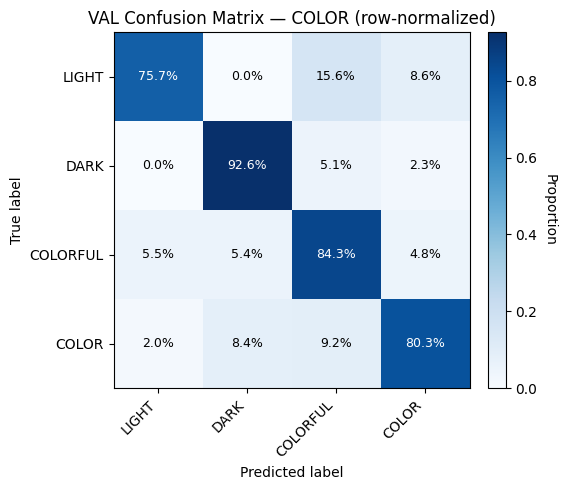

Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/cm_fabric_val.png


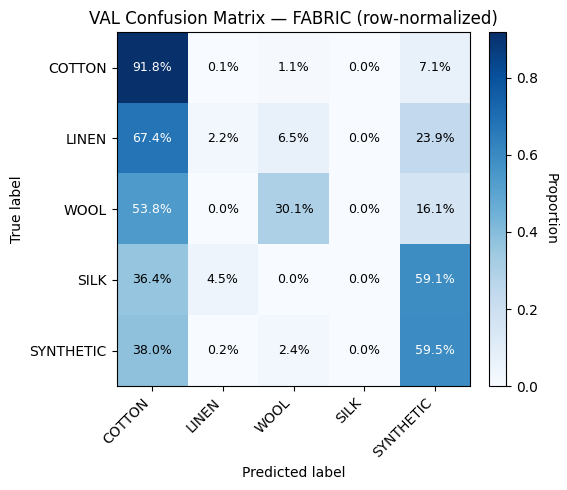

Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/cm_wash_val.png


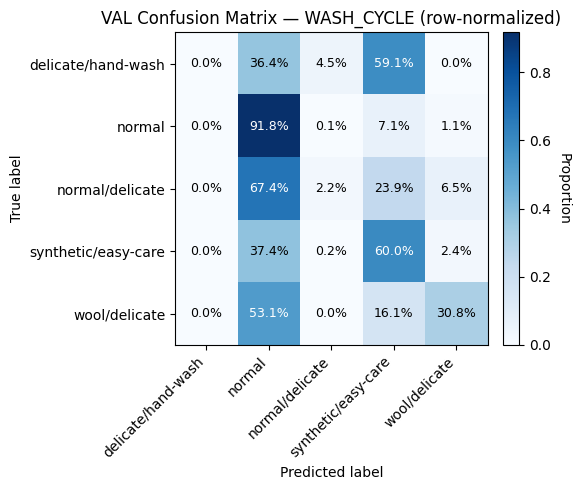


Saved per-class accuracies to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/val_per_class_accuracies.csv


/tmp/ipython-input-1938417833.py:373: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(names))


Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/per_class_accuracy_color.png


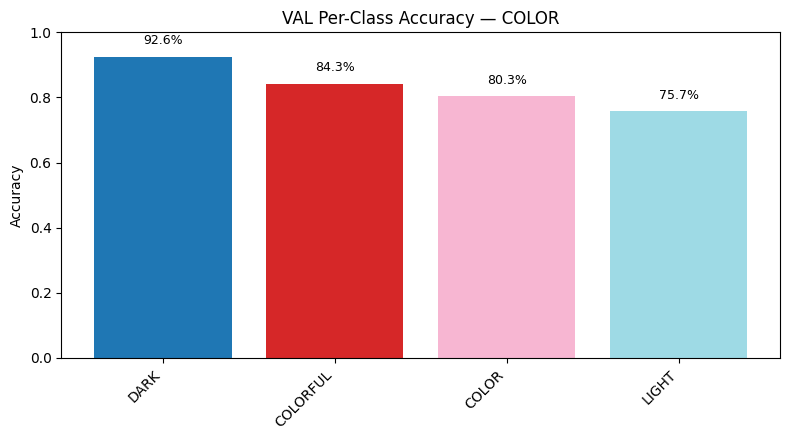

/tmp/ipython-input-1938417833.py:373: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(names))


Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/per_class_accuracy_fabric.png


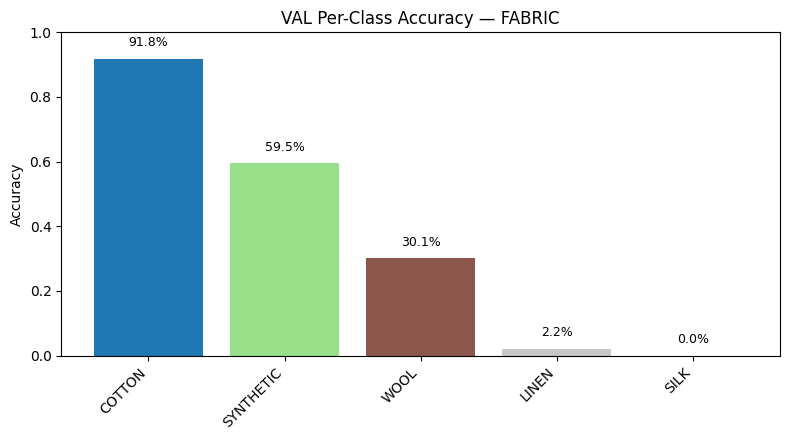

/tmp/ipython-input-1938417833.py:373: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(names))


Saved figure: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/per_class_accuracy_wash.png


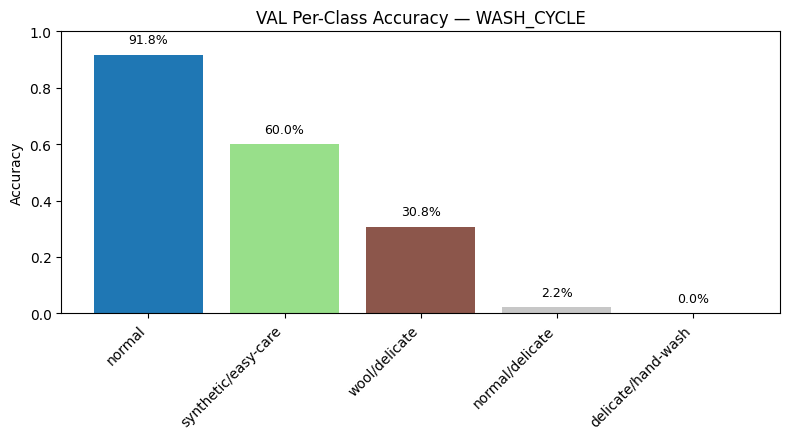


Showing some random validation examples (true vs predicted):

Saved example predictions figure to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/val_example_predictions.png


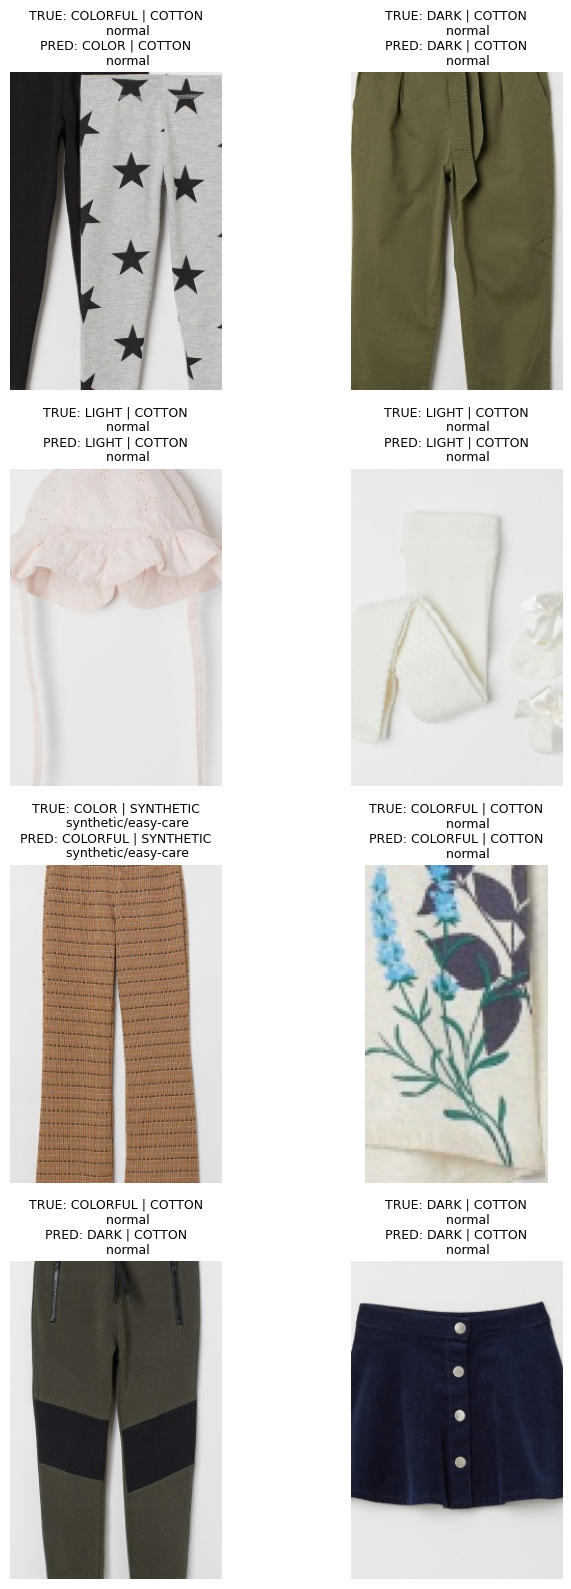

In [25]:
# =====================================================================
# FULL EVALUATION CELL (v2) — PROFESSIONAL REPORT
# ---------------------------------------------------------------------
# This script:
#   • Loads the best saved checkpoint of the multitask model
#   • Evaluates COLOR / FABRIC / WASH_CYCLE on the validation set
#   • Computes and SAVES:
#       - Row-normalized confusion matrices (as PNGs)
#       - Per-class accuracy bar charts (sorted, colored)
#   • Saves numeric metrics (overall + per-class) to CSV files
#   • Shows qualitative examples (true vs predicted labels)
# =====================================================================

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import timm

# ---------------------------------------------------------------------
# 0) Paths, device selection, and label loading
# ---------------------------------------------------------------------
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

assert os.path.exists(LABELS_CSV), f"Labels CSV not found: {LABELS_CSV}"
assert os.path.exists(CKPT_PATH),  f"Checkpoint not found: {CKPT_PATH}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df_labels = pd.read_csv(LABELS_CSV)
print("Loaded labels:", len(df_labels))

# Use only the validation split for evaluation
df_val = df_labels[df_labels["split"] == "val"].copy()
print("Validation rows:", len(df_val))

# Ensure label columns are integer-typed
df_val["color_label"]      = df_val["color_label"].astype(int)
df_val["fabric_label"]     = df_val["fabric_label"].astype(int)
df_val["wash_cycle_label"] = df_val["wash_cycle_label"].astype(int)

# Class counts must match training (use global df_labels, not only VAL)
num_color_classes  = df_labels["color_label"].astype(int).nunique()
num_fabric_classes = df_labels["fabric_label"].astype(int).nunique()
num_wash_classes   = df_labels["wash_cycle_label"].astype(int).nunique()

print(f"GLOBAL COLOR classes     : {num_color_classes}")
print(f"GLOBAL FABRIC classes    : {num_fabric_classes}")
print(f"GLOBAL WASH_CYCLE classes: {num_wash_classes}")

# Build index → name mappings from the VAL set (for readable axes)
color_map  = df_val.groupby("color_label")["color_group"]     .agg(lambda x: x.mode()[0]).to_dict()
fabric_map = df_val.groupby("fabric_label")["fabric_group"]   .agg(lambda x: x.mode()[0]).to_dict()
wash_map   = df_val.groupby("wash_cycle_label")["wash_cycle"] .agg(lambda x: x.mode()[0]).to_dict()

color_indices  = sorted(color_map.keys())
fabric_indices = sorted(fabric_map.keys())
wash_indices   = sorted(wash_map.keys())

color_names  = [color_map[i]  for i in color_indices]
fabric_names = [fabric_map[i] for i in fabric_indices]
wash_names   = [wash_map[i]   for i in wash_indices]

print("\nColor classes:",      list(zip(color_indices,  color_names)))
print("Fabric classes:",      list(zip(fabric_indices, fabric_names)))
print("Wash-cycle classes:",  list(zip(wash_indices,   wash_names)))

# ---------------------------------------------------------------------
# 1) Dataset and transforms for the validation set
# ---------------------------------------------------------------------
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class WashValDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        y_color      = int(row["color_label"])
        y_fabric     = int(row["fabric_label"])
        y_wash_cycle = int(row["wash_cycle_label"])

        return (
            img,
            torch.tensor(y_color,      dtype=torch.long),
            torch.tensor(y_fabric,     dtype=torch.long),
            torch.tensor(y_wash_cycle, dtype=torch.long),
        )

val_dataset = WashValDataset(df_val, transform=val_transform)
val_loader  = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,   # 0 to avoid multiprocessing warnings in Colab
    pin_memory=True,
)

# ---------------------------------------------------------------------
# 2) Model definition (must match the training configuration)
# ---------------------------------------------------------------------
BACKBONE_NAME = "convnext_tiny"   # For a stronger model, you can switch to "convnext_base"

class WashMultiTaskConvNeXt(nn.Module):
    def __init__(self,
                 backbone_name=BACKBONE_NAME,
                 num_color=4,
                 num_fabric=5,
                 num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,   # We will load weights from the checkpoint
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

# Load the best checkpoint
state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("\nLoaded best model from:", CKPT_PATH)

# ---------------------------------------------------------------------
# 3) Run inference on VAL and collect predictions
# ---------------------------------------------------------------------
all_y_color,  all_p_color  = [], []
all_y_fabric, all_p_fabric = [], []
all_y_wash,   all_p_wash   = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating on VAL"):
        imgs, y_color, y_fabric, y_wash = batch

        imgs     = imgs.to(device, non_blocking=True)
        y_color  = y_color.to(device)
        y_fabric = y_fabric.to(device)
        y_wash   = y_wash.to(device)

        logits_color, logits_fabric, logits_wash = model(imgs)

        preds_color  = logits_color.argmax(dim=1)
        preds_fabric = logits_fabric.argmax(dim=1)
        preds_wash   = logits_wash.argmax(dim=1)

        all_y_color.extend(y_color.cpu().numpy())
        all_p_color.extend(preds_color.cpu().numpy())

        all_y_fabric.extend(y_fabric.cpu().numpy())
        all_p_fabric.extend(preds_fabric.cpu().numpy())

        all_y_wash.extend(y_wash.cpu().numpy())
        all_p_wash.extend(preds_wash.cpu().numpy())

all_y_color  = np.array(all_y_color)
all_p_color  = np.array(all_p_color)
all_y_fabric = np.array(all_y_fabric)
all_p_fabric = np.array(all_p_fabric)
all_y_wash   = np.array(all_y_wash)
all_p_wash   = np.array(all_p_wash)

# ---------------------------------------------------------------------
# 4) Overall accuracies and saving numeric summary
# ---------------------------------------------------------------------
color_accuracy  = (all_y_color  == all_p_color).mean()
fabric_accuracy = (all_y_fabric == all_p_fabric).mean()
wash_accuracy   = (all_y_wash   == all_p_wash).mean()

print("\n=== VALIDATION ACCURACIES ===")
print(f"Color accuracy      : {color_accuracy  * 100:5.2f}%")
print(f"Fabric accuracy     : {fabric_accuracy * 100:5.2f}%")
print(f"Wash-cycle accuracy : {wash_accuracy   * 100:5.2f}%")

metrics_df = pd.DataFrame({
    "metric": ["color_accuracy", "fabric_accuracy", "wash_cycle_accuracy"],
    "value":  [color_accuracy,   fabric_accuracy,   wash_accuracy],
})
metrics_path = os.path.join(OUTPUT_DIR, "val_overall_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\nSaved overall validation metrics to:", metrics_path)

# ---------------------------------------------------------------------
# 5) Confusion matrix plotting helper (row-normalized)
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, classes, title, filename, normalize=True):
    """
    cm        : confusion matrix (numpy array)
    classes   : list of class names (for axes)
    title     : plot title
    filename  : output file name (saved under OUTPUT_DIR)
    normalize : if True, show row-wise proportions
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Proportion", rotation=-90, va="bottom")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            text_value = 100.0 * cm[i, j]
            s = f"{text_value:.1f}%"
        else:
            s = str(cm[i, j])
        ax.text(
            j, i, s,
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=9,
        )

    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    fig.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, filename)
    fig.savefig(save_path, dpi=200, bbox_inches="tight")
    print("Saved figure:", save_path)

    plt.show()

# Confusion matrices (row-normalized)
cm_color  = confusion_matrix(all_y_color,  all_p_color,  labels=color_indices)
cm_fabric = confusion_matrix(all_y_fabric, all_p_fabric, labels=fabric_indices)
cm_wash   = confusion_matrix(all_y_wash,   all_p_wash,   labels=wash_indices)

plot_confusion_matrix(
    cm_color,
    color_names,
    "VAL Confusion Matrix — COLOR (row-normalized)",
    "cm_color_val.png",
)

plot_confusion_matrix(
    cm_fabric,
    fabric_names,
    "VAL Confusion Matrix — FABRIC (row-normalized)",
    "cm_fabric_val.png",
)

plot_confusion_matrix(
    cm_wash,
    wash_names,
    "VAL Confusion Matrix — WASH_CYCLE (row-normalized)",
    "cm_wash_val.png",
)

# ---------------------------------------------------------------------
# 6) Per-class accuracies and bar plots (sorted, colored)
# ---------------------------------------------------------------------
def per_class_accuracy(all_true, all_pred, indices, names, task_name):
    """
    Compute per-class accuracy for a given task.
    Returns a DataFrame with:
      task, class_index, class_name, support, accuracy
    """
    rows = []
    for idx, name in zip(indices, names):
        mask = (all_true == idx)
        support = mask.sum()
        if support == 0:
            acc = np.nan
        else:
            acc = (all_pred[mask] == all_true[mask]).mean()
        rows.append({
            "task":        task_name,
            "class_index": idx,
            "class_name":  name,
            "support":     int(support),
            "accuracy":    float(acc),
        })
    return pd.DataFrame(rows)

df_color_acc  = per_class_accuracy(
    all_y_color,  all_p_color,  color_indices,  color_names,  "COLOR"
)
df_fabric_acc = per_class_accuracy(
    all_y_fabric, all_p_fabric, fabric_indices, fabric_names, "FABRIC"
)
df_wash_acc   = per_class_accuracy(
    all_y_wash,   all_p_wash,   wash_indices,   wash_names,   "WASH_CYCLE"
)

per_class_df = pd.concat([df_color_acc, df_fabric_acc, df_wash_acc], ignore_index=True)
per_class_path = os.path.join(OUTPUT_DIR, "val_per_class_accuracies.csv")
per_class_df.to_csv(per_class_path, index=False)
print("\nSaved per-class accuracies to:", per_class_path)

def plot_per_class_bar(df_task, title, filename):
    """
    Plot a per-class accuracy bar chart:
      - rows sorted by accuracy (high → low)
      - each bar with a distinct color
    """
    # Drop classes with NaN accuracy (no samples in VAL)
    df_plot = df_task.dropna(subset=["accuracy"]).copy()

    # Sort by accuracy (descending), then by class name
    df_plot = df_plot.sort_values(
        ["accuracy", "class_name"],
        ascending=[False, True]
    ).reset_index(drop=True)

    names      = df_plot["class_name"].tolist()
    accuracies = df_plot["accuracy"].tolist()

    x = np.arange(len(names))

    # Use a qualitative colormap for visual distinction
    cmap = plt.cm.get_cmap("tab20", len(names))
    colors = [cmap(i) for i in range(len(names))]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(x, accuracies, color=colors)

    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0.0, 1.0)
    ax.set_title(title)

    # Add percentage labels above each bar
    for xi, acc in zip(x, accuracies):
        text = f"{acc * 100:.1f}%"
        y = min(acc + 0.03, 1.02)
        ax.text(xi, y, text, ha="center", va="bottom", fontsize=9)

    fig.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, filename)
    fig.savefig(save_path, dpi=200, bbox_inches="tight")
    print("Saved figure:", save_path)
    plt.show()

plot_per_class_bar(
    df_color_acc,
    "VAL Per-Class Accuracy — COLOR",
    "per_class_accuracy_color.png",
)

plot_per_class_bar(
    df_fabric_acc,
    "VAL Per-Class Accuracy — FABRIC",
    "per_class_accuracy_fabric.png",
)

plot_per_class_bar(
    df_wash_acc,
    "VAL Per-Class Accuracy — WASH_CYCLE",
    "per_class_accuracy_wash.png",
)

# ---------------------------------------------------------------------
# 7) Qualitative examples: random VAL images (true vs predicted)
# ---------------------------------------------------------------------
idx2color  = {k: v for k, v in color_map.items()}
idx2fabric = {k: v for k, v in fabric_map.items()}
idx2wash   = {k: v for k, v in wash_map.items()}

def show_random_examples(n=8, seed=42):
    subset = df_val.sample(n, random_state=seed).reset_index(drop=True)

    model.eval()
    rows = int(np.ceil(n / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(8, 4 * rows))
    axes = np.array(axes).reshape(-1)

    for i in range(len(subset)):
        row = subset.iloc[i]
        img_path = row["image_path"]

        img_pil = Image.open(img_path).convert("RGB")
        x = val_transform(img_pil).unsqueeze(0).to(device)

        with torch.no_grad():
            logits_c, logits_f, logits_w = model(x)
            pc = logits_c.argmax(dim=1).item()
            pf = logits_f.argmax(dim=1).item()
            pw = logits_w.argmax(dim=1).item()

        true_c = idx2color[row["color_label"]]
        true_f = idx2fabric[row["fabric_label"]]
        true_w = idx2wash[row["wash_cycle_label"]]

        pred_c = idx2color[pc]
        pred_f = idx2fabric[pf]
        pred_w = idx2wash[pw]

        ax = axes[i]
        ax.imshow(img_pil)
        ax.axis("off")
        ax.set_title(
            f"TRUE: {true_c} | {true_f}\n"
            f"      {true_w}\n"
            f"PRED: {pred_c} | {pred_f}\n"
            f"      {pred_w}",
            fontsize=9,
        )

    # Hide unused subplots if n is odd
    for j in range(len(subset), len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    examples_path = os.path.join(OUTPUT_DIR, "val_example_predictions.png")
    fig.savefig(examples_path, dpi=200, bbox_inches="tight")
    print("\nSaved example predictions figure to:", examples_path)
    plt.show()

print("\nShowing some random validation examples (true vs predicted):")
show_random_examples(n=8, seed=0)


In [26]:
# ============================================================
# Cell 8 — Save label mappings (COLOR / FABRIC / WASH_CYCLE)
# ============================================================

import os
import pandas as pd

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(LABELS_CSV)

# Extract unique mappings
color_map_df = (
    df[["color_label", "color_group"]]
    .drop_duplicates()
    .sort_values("color_label")
    .reset_index(drop=True)
)
fabric_map_df = (
    df[["fabric_label", "fabric_group"]]
    .drop_duplicates()
    .sort_values("fabric_label")
    .reset_index(drop=True)
)
wash_map_df = (
    df[["wash_cycle_label", "wash_cycle"]]
    .drop_duplicates()
    .sort_values("wash_cycle_label")
    .reset_index(drop=True)
)

color_map_path  = os.path.join(OUTPUT_DIR, "mapping_color_label.csv")
fabric_map_path = os.path.join(OUTPUT_DIR, "mapping_fabric_label.csv")
wash_map_path   = os.path.join(OUTPUT_DIR, "mapping_wash_cycle_label.csv")

color_map_df.to_csv(color_map_path,  index=False)
fabric_map_df.to_csv(fabric_map_path, index=False)
wash_map_df.to_csv(wash_map_path,   index=False)

print("Saved COLOR mapping to :", color_map_path)
print("Saved FABRIC mapping to:", fabric_map_path)
print("Saved WASH_CYCLE mapping to:", wash_map_path)


Saved COLOR mapping to : /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/mapping_color_label.csv
Saved FABRIC mapping to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/mapping_fabric_label.csv
Saved WASH_CYCLE mapping to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/mapping_wash_cycle_label.csv


In [27]:
# ============================================================
# Cell 9 — Batch inference for DEMO and save demo_predictions.csv
# ============================================================

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import timm
import torch.nn as nn

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

assert os.path.exists(LABELS_CSV), f"Labels CSV not found: {LABELS_CSV}"
assert os.path.exists(CKPT_PATH),  f"Checkpoint not found: {CKPT_PATH}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df_all = pd.read_csv(LABELS_CSV)
print("Total rows:", len(df_all))

df_eval = df_all.copy()       # val:  df_all[df_all["split"]=="val"].copy()

df_eval["color_label"]      = df_eval["color_label"].astype(int)
df_eval["fabric_label"]     = df_eval["fabric_label"].astype(int)
df_eval["wash_cycle_label"] = df_eval["wash_cycle_label"].astype(int)

num_color_classes  = df_all["color_label"].astype(int).nunique()
num_fabric_classes = df_all["fabric_label"].astype(int).nunique()
num_wash_classes   = df_all["wash_cycle_label"].astype(int).nunique()

IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class WashDemoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return (
            img,
            row["image_path"],
            int(row["color_label"]),
            int(row["fabric_label"]),
            int(row["wash_cycle_label"]),
        )

demo_dataset = WashDemoDataset(df_eval, transform=eval_transform)
demo_loader  = DataLoader(
    demo_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

BACKBONE_NAME = "convnext_tiny"

class WashMultiTaskConvNeXt(nn.Module):
    def __init__(self,
                 backbone_name=BACKBONE_NAME,
                 num_color=4,
                 num_fabric=5,
                 num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features
        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("\nRunning batch inference on all eval rows ...")

rows_out = []

with torch.no_grad():
    for batch in tqdm(demo_loader, desc="Demo inference"):
        imgs, paths, y_c_true, y_f_true, y_w_true = batch
        imgs = imgs.to(device, non_blocking=True)

        logits_c, logits_f, logits_w = model(imgs)

        y_c_pred = logits_c.argmax(dim=1).cpu().numpy()
        y_f_pred = logits_f.argmax(dim=1).cpu().numpy()
        y_w_pred = logits_w.argmax(dim=1).cpu().numpy()

        # convert numpy
        y_c_true = y_c_true.numpy()
        y_f_true = y_f_true.numpy()
        y_w_true = y_w_true.numpy()

        for p, c_t, f_t, w_t, c_p, f_p, w_p in zip(
            paths, y_c_true, y_f_true, y_w_true, y_c_pred, y_f_pred, y_w_pred
        ):
            rows_out.append({
                "image_path":        p,
                "color_label_true":  int(c_t),
                "fabric_label_true": int(f_t),
                "wash_label_true":   int(w_t),
                "color_label_pred":  int(c_p),
                "fabric_label_pred": int(f_p),
                "wash_label_pred":   int(w_p),
            })

demo_df = pd.DataFrame(rows_out)
demo_csv_path = os.path.join(OUTPUT_DIR, "demo_predictions.csv")
demo_df.to_csv(demo_csv_path, index=False)

print("\nSaved demo predictions CSV to:", demo_csv_path)
print("Head:")
print(demo_df.head())


Using device: cuda
Total rows: 13593

Running batch inference on all eval rows ...


Demo inference:   0%|          | 0/425 [00:00<?, ?it/s]


Saved demo predictions CSV to: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/demo_predictions.csv
Head:
                                          image_path  color_label_true  \
0  /content/drive/MyDrive/wash_ai_outputs/crops_b...                 0   
1  /content/drive/MyDrive/wash_ai_outputs/crops_b...                 2   
2  /content/drive/MyDrive/wash_ai_outputs/crops_b...                 2   
3  /content/drive/MyDrive/wash_ai_outputs/crops_b...                 2   
4  /content/drive/MyDrive/wash_ai_outputs/crops_b...                 3   

   fabric_label_true  wash_label_true  color_label_pred  fabric_label_pred  \
0                  0                1                 0                  0   
1                  0                1                 2                  0   
2                  4                3                 2                  0   
3                  0                1                 2                  0   
4                  0                1       

In [28]:
# ============================================================
# Cell 10 — Single-image DEMO helper + logging
# ============================================================

import os
import datetime
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import timm
import torch.nn as nn

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df_all = pd.read_csv(LABELS_CSV)
num_color_classes  = df_all["color_label"].astype(int).nunique()
num_fabric_classes = df_all["fabric_label"].astype(int).nunique()
num_wash_classes   = df_all["wash_cycle_label"].astype(int).nunique()

# conver label -> name
color_map_df  = df_all[["color_label","color_group"]].drop_duplicates()
fabric_map_df = df_all[["fabric_label","fabric_group"]].drop_duplicates()
wash_map_df   = df_all[["wash_cycle_label","wash_cycle"]].drop_duplicates()

idx2color  = dict(zip(color_map_df["color_label"],  color_map_df["color_group"]))
idx2fabric = dict(zip(fabric_map_df["fabric_label"], fabric_map_df["fabric_group"]))
idx2wash   = dict(zip(wash_map_df["wash_cycle_label"], wash_map_df["wash_cycle"]))

IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

BACKBONE_NAME = "convnext_tiny"

class WashMultiTaskConvNeXt(nn.Module):
    def __init__(self,
                 backbone_name=BACKBONE_NAME,
                 num_color=4,
                 num_fabric=5,
                 num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features
        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

demo_log_path = os.path.join(OUTPUT_DIR, "demo_usage_log.csv")

def run_demo_on_image(img_path: str):
    """
    Run the trained multitask model on a single image and:
      - print predicted color_group / fabric_group / wash_cycle
      - append results to demo_usage_log.csv
    """
    assert os.path.exists(img_path), f"Image not found: {img_path}"

    img_pil = Image.open(img_path).convert("RGB")
    x = demo_transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits_c, logits_f, logits_w = model(x)
        pc = logits_c.argmax(dim=1).item()
        pf = logits_f.argmax(dim=1).item()
        pw = logits_w.argmax(dim=1).item()

    pred_color_name  = idx2color.get(pc,  f"color_{pc}")
    pred_fabric_name = idx2fabric.get(pf, f"fabric_{pf}")
    pred_wash_name   = idx2wash.get(pw,  f"wash_{pw}")

    print("\n=== DEMO RESULT ===")
    print("Image path      :", img_path)
    print("Pred COLOR      :", pred_color_name,  f"(label={pc})")
    print("Pred FABRIC     :", pred_fabric_name, f"(label={pf})")
    print("Pred WASH_CYCLE :", pred_wash_name,   f"(label={pw})")

    # Log to CSV
    ts = datetime.datetime.now().isoformat(timespec="seconds")
    row = {
        "timestamp": ts,
        "image_path": img_path,
        "pred_color_label":  pc,
        "pred_color_group":  pred_color_name,
        "pred_fabric_label": pf,
        "pred_fabric_group": pred_fabric_name,
        "pred_wash_label":   pw,
        "pred_wash_cycle":   pred_wash_name,
    }

    if os.path.exists(demo_log_path):
        log_df = pd.read_csv(demo_log_path)
        log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)
    else:
        log_df = pd.DataFrame([row])

    log_df.to_csv(demo_log_path, index=False)
    print("\nLogged DEMO call to:", demo_log_path)

    return {
        "color_group":  pred_color_name,
        "fabric_group": pred_fabric_name,
        "wash_cycle":   pred_wash_name,
    }


# result = run_demo_on_image("/content/drive/MyDrive/wash_ai_project/some_test_image.jpg")
# print(result)


In [29]:
# ============================================================
# Cell C — Professional Single-Image Demo + Logging
# ============================================================

import os
import datetime
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
import timm

WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df_all = pd.read_csv(LABELS_CSV)
num_color_classes  = df_all["color_label"].astype(int).nunique()
num_fabric_classes = df_all["fabric_label"].astype(int).nunique()
num_wash_classes   = df_all["wash_cycle_label"].astype(int).nunique()

# Label index → human-readable name
color_map_df  = df_all[["color_label", "color_group"]].drop_duplicates()
fabric_map_df = df_all[["fabric_label", "fabric_group"]].drop_duplicates()
wash_map_df   = df_all[["wash_cycle_label", "wash_cycle"]].drop_duplicates()

idx2color  = dict(zip(color_map_df["color_label"],  color_map_df["color_group"]))
idx2fabric = dict(zip(fabric_map_df["fabric_label"], fabric_map_df["fabric_group"]))
idx2wash   = dict(zip(wash_map_df["wash_cycle_label"], wash_map_df["wash_cycle"]))

IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

BACKBONE_NAME = "convnext_tiny"

class WashMultiTaskConvNeXt(nn.Module):
    """
    Same architecture as used during training/evaluation.
    """
    def __init__(self,
                 backbone_name=BACKBONE_NAME,
                 num_color=4,
                 num_fabric=5,
                 num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

demo_log_path = os.path.join(OUTPUT_DIR, "demo_usage_log.csv")

def run_demo_on_image(img_path: str, show_image: bool = True):
    """
    Run the trained model on a single garment image and:
      - predict color_group / fabric_group / wash_cycle
      - print a structured summary
      - optionally display the image with a professional title
      - append the result to demo_usage_log.csv

    Returns a dictionary with the predicted attributes.
    """
    assert os.path.exists(img_path), f"Image not found: {img_path}"

    # Load and preprocess image
    img_pil = Image.open(img_path).convert("RGB")
    x = demo_transform(img_pil).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        logits_c, logits_f, logits_w = model(x)
        pc = logits_c.argmax(dim=1).item()
        pf = logits_f.argmax(dim=1).item()
        pw = logits_w.argmax(dim=1).item()

    pred_color_name  = idx2color.get(pc,  f"color_{pc}")
    pred_fabric_name = idx2fabric.get(pf, f"fabric_{pf}")
    pred_wash_name   = idx2wash.get(pw,  f"wash_{pw}")

    print("\n========================================")
    print(" SMART WASHING ASSISTANT — DEMO RESULT")
    print("========================================")
    print(f"Image path       : {img_path}")
    print("----------------------------------------")
    print(f"Predicted COLOR  : {pred_color_name}  (label = {pc})")
    print(f"Predicted FABRIC : {pred_fabric_name} (label = {pf})")
    print(f"Predicted PROGRAM: {pred_wash_name}   (label = {pw})")
    print("========================================\n")

    # Optional visualization
    if show_image:
        plt.figure(figsize=(4, 4))
        plt.imshow(img_pil)
        plt.axis("off")
        plt.title(
            f"COLOR: {pred_color_name}\n"
            f"FABRIC: {pred_fabric_name}\n"
            f"WASH: {pred_wash_name}",
            fontsize=10,
        )
        plt.tight_layout()
        plt.show()

    # Log to CSV
    ts = datetime.datetime.now().isoformat(timespec="seconds")
    row = {
        "timestamp": ts,
        "image_path": img_path,
        "pred_color_label":  pc,
        "pred_color_group":  pred_color_name,
        "pred_fabric_label": pf,
        "pred_fabric_group": pred_fabric_name,
        "pred_wash_label":   pw,
        "pred_wash_cycle":   pred_wash_name,
    }

    if os.path.exists(demo_log_path):
        log_df = pd.read_csv(demo_log_path)
        log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)
    else:
        log_df = pd.DataFrame([row])

    log_df.to_csv(demo_log_path, index=False)
    print("Logged DEMO call to:", demo_log_path)

    return {
        "color_group":  pred_color_name,
        "fabric_group": pred_fabric_name,
        "wash_cycle":   pred_wash_name,
    }

# Example (uncomment and set your path):
# result = run_demo_on_image("/content/drive/MyDrive/wash_ai_project/demo/test_shirt.jpg")
# print(result)


Using device: cuda


In [32]:
!pip install gradio -q


In [33]:
# ============================================================
# Cell D — Web Demo (Gradio) for Smart Washing Assistant
# - Upload any garment image → model predicts:
#       * color_group
#       * fabric_group
#       * wash_cycle (program name)
# - Launches a public link (share=True) you can open on phone/PC
# ============================================================

import os
import datetime
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
import timm
import gradio as gr

# -----------------------------
# 0) Paths, device, meta info
# -----------------------------
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

assert os.path.exists(LABELS_CSV), f"Labels CSV not found: {LABELS_CSV}"
assert os.path.exists(CKPT_PATH),  f"Checkpoint not found: {CKPT_PATH}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load labels to reconstruct mappings
df_all = pd.read_csv(LABELS_CSV)

df_all["color_label"]       = df_all["color_label"].astype(int)
df_all["fabric_label"]      = df_all["fabric_label"].astype(int)
df_all["wash_cycle_label"]  = df_all["wash_cycle_label"].astype(int)

num_color_classes  = df_all["color_label"].nunique()
num_fabric_classes = df_all["fabric_label"].nunique()
num_wash_classes   = df_all["wash_cycle_label"].nunique()

# Label index → human-readable name
color_map_df  = df_all[["color_label", "color_group"]].drop_duplicates()
fabric_map_df = df_all[["fabric_label", "fabric_group"]].drop_duplicates()
wash_map_df   = df_all[["wash_cycle_label", "wash_cycle"]].drop_duplicates()

idx2color  = dict(zip(color_map_df["color_label"],  color_map_df["color_group"]))
idx2fabric = dict(zip(fabric_map_df["fabric_label"], fabric_map_df["fabric_group"]))
idx2wash   = dict(zip(wash_map_df["wash_cycle_label"], wash_map_df["wash_cycle"]))

# -----------------------------
# 1) Transforms (same as demo)
# -----------------------------
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# -----------------------------
# 2) Model definition + load
# -----------------------------
BACKBONE_NAME = "convnext_tiny"

class WashMultiTaskConvNeXt(nn.Module):
    """
    Same architecture as used during training.
    """
    def __init__(self,
                 backbone_name=BACKBONE_NAME,
                 num_color=4,
                 num_fabric=5,
                 num_wash=5):
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,   # weights come from checkpoint
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle

model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded from:", CKPT_PATH)

demo_log_path = os.path.join(OUTPUT_DIR, "web_demo_usage_log.csv")

# -----------------------------
# 3) Core prediction function
# -----------------------------
def predict_garment(image):
    """
    Gradio-inference function.

    Input:
      image: PIL.Image (from Gradio Image component)

    Output:
      color_group (str),
      fabric_group (str),
      wash_cycle (str),
      full_summary (str)
    """
    if image is None:
        return "", "", "", "No image uploaded."

    # Convert to RGB PIL just in case
    img_pil = image.convert("RGB")
    x = demo_transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits_c, logits_f, logits_w = model(x)
        pc = logits_c.argmax(dim=1).item()
        pf = logits_f.argmax(dim=1).item()
        pw = logits_w.argmax(dim=1).item()

    pred_color_name  = idx2color.get(pc,  f"color_{pc}")
    pred_fabric_name = idx2fabric.get(pf, f"fabric_{pf}")
    pred_wash_name   = idx2wash.get(pw,  f"wash_{pw}")

    # Build a nice textual summary (for the 4th output)
    summary_lines = [
        "SMART WASHING ASSISTANT — PREDICTION",
        "",
        f"Predicted COLOR group : {pred_color_name}  (label = {pc})",
        f"Predicted FABRIC      : {pred_fabric_name} (label = {pf})",
        f"Recommended PROGRAM   : {pred_wash_name}   (label = {pw})",
    ]
    summary_text = "\n".join(summary_lines)

    # Log to CSV (no image path here, user upload is ad-hoc)
    ts = datetime.datetime.now().isoformat(timespec="seconds")
    row = {
        "timestamp": ts,
        "pred_color_label":  pc,
        "pred_color_group":  pred_color_name,
        "pred_fabric_label": pf,
        "pred_fabric_group": pred_fabric_name,
        "pred_wash_label":   pw,
        "pred_wash_cycle":   pred_wash_name,
    }

    if os.path.exists(demo_log_path):
        log_df = pd.read_csv(demo_log_path)
        log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)
    else:
        log_df = pd.DataFrame([row])

    log_df.to_csv(demo_log_path, index=False)

    return pred_color_name, pred_fabric_name, pred_wash_name, summary_text

# -----------------------------
# 4) Gradio UI
# -----------------------------
title_md = """
# 🧺 Smart Washing Assistant — Web Demo

Upload a **single garment photo** (front view if possible).
The model will predict:

- **Color group** (LIGHT / DARK / COLOR / COLORFUL)
- **Fabric group** (COTTON, LINEN, WOOL, SILK, SYNTHETIC)
- **Recommended washing program** (wash_cycle)
"""

with gr.Blocks() as demo:
    gr.Markdown(title_md)

    with gr.Row():
        with gr.Column():
            img_input = gr.Image(
                type="pil",
                label="Upload garment image",
            )
            run_btn = gr.Button("Analyze garment 🧼", variant="primary")

        with gr.Column():
            color_out  = gr.Textbox(label="Predicted COLOR group")
            fabric_out = gr.Textbox(label="Predicted FABRIC group")
            wash_out   = gr.Textbox(label="Recommended WASH PROGRAM")
            summary_out = gr.Textbox(
                label="Full prediction summary",
                lines=6,
            )

    run_btn.click(
        fn=predict_garment,
        inputs=img_input,
        outputs=[color_out, fabric_out, wash_out, summary_out],
    )

# Launch app — share=True gives you a public link
demo.launch(share=True)


Using device: cuda
Model loaded from: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2c529b9857d462c081.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [34]:
# ============================================================
# Cell D (Improved) — Smart Washing Assistant Web Demo (Gradio)
# ============================================================

import os
import datetime
from typing import Dict, Any, Tuple

import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
import timm
import gradio as gr

# ------------------------------------------------------------
# 0) Paths, device, and metadata
# ------------------------------------------------------------
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
OUTPUT_DIR  = os.path.join(WASH_ROOT, "outputs_multitask_wash")
CKPT_PATH   = os.path.join(OUTPUT_DIR, "best_model_wash.pt")

assert os.path.exists(LABELS_CSV), f"Labels CSV not found: {LABELS_CSV}"
assert os.path.exists(CKPT_PATH),  f"Checkpoint not found: {CKPT_PATH}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load labels to reconstruct mappings and class counts
df_all = pd.read_csv(LABELS_CSV)

df_all["color_label"]       = df_all["color_label"].astype(int)
df_all["fabric_label"]      = df_all["fabric_label"].astype(int)
df_all["wash_cycle_label"]  = df_all["wash_cycle_label"].astype(int)

num_color_classes  = df_all["color_label"].nunique()
num_fabric_classes = df_all["fabric_label"].nunique()
num_wash_classes   = df_all["wash_cycle_label"].nunique()

# Label index → human-readable name
color_map_df  = df_all[["color_label", "color_group"]].drop_duplicates()
fabric_map_df = df_all[["fabric_label", "fabric_group"]].drop_duplicates()
wash_map_df   = df_all[["wash_cycle_label", "wash_cycle"]].drop_duplicates()

idx2color  = dict(zip(color_map_df["color_label"],  color_map_df["color_group"]))
idx2fabric = dict(zip(fabric_map_df["fabric_label"], fabric_map_df["fabric_group"]))
idx2wash   = dict(zip(wash_map_df["wash_cycle_label"], wash_map_df["wash_cycle"]))

# Optional: build a "canonical" example wash note per wash_cycle (mode of wash_notes)
if "wash_notes" in df_all.columns:
    wash_notes_map = (
        df_all.groupby("wash_cycle")["wash_notes"]
        .agg(lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "")
        .to_dict()
    )
else:
    wash_notes_map = {}

demo_log_path = os.path.join(OUTPUT_DIR, "web_demo_usage_log.csv")

# ------------------------------------------------------------
# 1) Image preprocessing
# ------------------------------------------------------------
IMG_SIZE = 256
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ------------------------------------------------------------
# 2) Model definition and loading
# ------------------------------------------------------------
BACKBONE_NAME = "convnext_tiny"

class WashMultiTaskConvNeXt(nn.Module):
    """
    Multi-task ConvNeXt model used for:
      - COLOR group classification
      - FABRIC group classification
      - WASH_CYCLE (washing program) classification
    """
    def __init__(
        self,
        backbone_name: str = BACKBONE_NAME,
        num_color: int = 4,
        num_fabric: int = 5,
        num_wash: int = 5,
    ) -> None:
        super().__init__()
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=False,     # weights come from the checkpoint
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle


# Instantiate and load the trained weights
model = WashMultiTaskConvNeXt(
    backbone_name=BACKBONE_NAME,
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("Model successfully loaded from:", CKPT_PATH)

# ------------------------------------------------------------
# 3) Core prediction function for Gradio
# ------------------------------------------------------------
def predict_garment(image: Image.Image) -> Tuple[str, str, str, str]:
    """
    Gradio inference function.

    Parameters
    ----------
    image : PIL.Image.Image
        Input garment image uploaded by the user.

    Returns
    -------
    color_group : str
        Predicted color group (e.g., LIGHT, DARK, COLOR).
    fabric_group : str
        Predicted fabric group (e.g., COTTON, WOOL).
    wash_program : str
        Predicted washing program name (wash_cycle).
    summary_text : str
        A formatted textual summary of the predictions.
    """
    if image is None:
        return "", "", "", "No image uploaded."

    # Ensure RGB
    img_pil = image.convert("RGB")
    x = demo_transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits_c, logits_f, logits_w = model(x)
        pc = logits_c.argmax(dim=1).item()
        pf = logits_f.argmax(dim=1).item()
        pw = logits_w.argmax(dim=1).item()

    pred_color_name  = idx2color.get(pc,  f"color_{pc}")
    pred_fabric_name = idx2fabric.get(pf, f"fabric_{pf}")
    pred_wash_name   = idx2wash.get(pw,  f"wash_{pw}")

    # Optional: attach a canonical note for this wash_cycle
    notes = wash_notes_map.get(pred_wash_name, "").strip()
    if notes:
        notes_line = f"\nSuggested care notes : {notes}"
    else:
        notes_line = ""

    summary_lines = [
        "SMART WASHING ASSISTANT — PREDICTION",
        "",
        f"Predicted COLOR group : {pred_color_name}  (label = {pc})",
        f"Predicted FABRIC      : {pred_fabric_name} (label = {pf})",
        f"Recommended PROGRAM   : {pred_wash_name}   (label = {pw})",
        notes_line,
    ]
    summary_text = "\n".join(line for line in summary_lines if line != "")

    # Log usage (without storing the raw image)
    timestamp = datetime.datetime.now().isoformat(timespec="seconds")
    log_row: Dict[str, Any] = {
        "timestamp":          timestamp,
        "pred_color_label":   pc,
        "pred_color_group":   pred_color_name,
        "pred_fabric_label":  pf,
        "pred_fabric_group":  pred_fabric_name,
        "pred_wash_label":    pw,
        "pred_wash_cycle":    pred_wash_name,
    }

    if os.path.exists(demo_log_path):
        log_df = pd.read_csv(demo_log_path)
        log_df = pd.concat([log_df, pd.DataFrame([log_row])], ignore_index=True)
    else:
        log_df = pd.DataFrame([log_row])

    log_df.to_csv(demo_log_path, index=False)

    return pred_color_name, pred_fabric_name, pred_wash_name, summary_text

# ------------------------------------------------------------
# 4) Gradio UI definition
# ------------------------------------------------------------
title_md = """
# 🧺 Smart Washing Assistant — Interactive Demo

Upload a **single garment photo** (preferably front view on plain background).
The model will predict:

- **Color group** (e.g., LIGHT / DARK / COLOR / COLORFUL)
- **Fabric group** (e.g., COTTON, LINEN, WOOL, SILK, SYNTHETIC)
- **Recommended washing program** (derived from your rule-based design)
"""

info_md = """
### ℹ️ How to use

1. Click on **“Upload garment image”** and select a photo from your device.
2. Press **“Analyze garment 🧼”**.
3. The predicted **color**, **fabric**, and **washing program** will appear on the right.

This demo runs your trained **ConvNeXt-based multi-task model** directly in Colab.
"""

footer_md = """
---
**Note:** This link stays active only while the Colab runtime is running.
All learned weights and logs are stored safely in your Google Drive project folder.
"""

theme = gr.themes.Soft(primary_hue="blue", neutral_hue="slate")

with gr.Blocks(theme=theme, title="Smart Washing Assistant") as demo:
    gr.Markdown(title_md)

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown(info_md)
            img_input = gr.Image(
                type="pil",
                label="Upload garment image",
            )
            run_btn = gr.Button("Analyze garment 🧼", variant="primary")
        with gr.Column(scale=1):
            color_out   = gr.Textbox(label="Predicted COLOR group", interactive=False)
            fabric_out  = gr.Textbox(label="Predicted FABRIC group", interactive=False)
            wash_out    = gr.Textbox(label="Recommended washing program", interactive=False)
            summary_out = gr.Textbox(
                label="Detailed prediction summary",
                lines=8,
                interactive=False,
            )

    with gr.Accordion("Model & system details", open=False):
        gr.Markdown(
            f"""
- Backbone: **{BACKBONE_NAME}**
- Device: **{device}**
- #COLOR classes: **{num_color_classes}**
- #FABRIC classes: **{num_fabric_classes}**
- #WASH_CYCLE classes: **{num_wash_classes}**
- Checkpoint path: `{CKPT_PATH}`
"""
        )

    gr.Markdown(footer_md)

    run_btn.click(
        fn=predict_garment,
        inputs=img_input,
        outputs=[color_out, fabric_out, wash_out, summary_out],
    )

# Queue allows concurrent users (nice for a demo)
demo.queue()

# Launch app — share=True gives you a public URL
demo.launch(share=True, show_api=False)


Using device: cuda
Model successfully loaded from: /content/drive/MyDrive/wash_ai_project/outputs_multitask_wash/best_model_wash.pt
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f4acd812d0fb68b75b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [57]:
from google.colab import drive
drive.mount('/content/drive')

import os

WASH_ROOT = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV = os.path.join(WASH_ROOT, "wash_labels.csv")
CKPT_PATH = os.path.join(WASH_ROOT, "outputs_multitask_wash", "best_model_wash.pt")
HEADER_IMG = os.path.join(WASH_ROOT, "ai.jpg")

print("wash_labels.csv:", os.path.exists(LABELS_CSV))
print("best_model_wash.pt:", os.path.exists(CKPT_PATH))
print("ai.jpg:", os.path.exists(HEADER_IMG))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
wash_labels.csv: True
best_model_wash.pt: True
ai.jpg: True


In [58]:
!pip install -q streamlit pyngrok timm

from pyngrok import ngrok

NGROK_TOKEN = "اینجا authtoken خودت"
ngrok.set_auth_token(NGROK_TOKEN)
print("ngrok token set ")


ngrok token set 


In [62]:
%%writefile app.py
"""
AI Laundry Sorter – Streamlit Demo (fixed)
- Compatible with training checkpoint (head_wash_cycle)
- No numeric labels in UI
- Full descriptive wash program names
"""

import os
import io
import datetime

import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms
import timm

import streamlit as st

# --------------------------------------------------
# 0) Paths
# --------------------------------------------------
WASH_ROOT   = "/content/drive/MyDrive/wash_ai_project"
LABELS_CSV  = os.path.join(WASH_ROOT, "wash_labels.csv")
CKPT_PATH   = os.path.join(WASH_ROOT, "outputs_multitask_wash", "best_model_wash.pt")
HEADER_IMG  = os.path.join(WASH_ROOT, "ai.jpg")
DEMO_LOG    = os.path.join(WASH_ROOT, "demo_usage_log.csv")

# --------------------------------------------------
# 1) Label metadata
# --------------------------------------------------
df_all = pd.read_csv(LABELS_CSV)

df_all["color_label"]      = df_all["color_label"].astype(int)
df_all["fabric_label"]     = df_all["fabric_label"].astype(int)
df_all["wash_cycle_label"] = df_all["wash_cycle_label"].astype(int)

num_color_classes  = df_all["color_label"].nunique()
num_fabric_classes = df_all["fabric_label"].nunique()
num_wash_classes   = df_all["wash_cycle_label"].nunique()

color_map  = dict(zip(df_all["color_label"],  df_all["color_group"]))
fabric_map = dict(zip(df_all["fabric_label"], df_all["fabric_group"]))
wash_map   = dict(zip(df_all["wash_cycle_label"], df_all["wash_cycle"]))

# Full descriptive wash-cycle names
wash_full_description = {
    "delicate": "Delicate – Gentle wash, cold water, low spin (ideal for silk, lace, sensitive fabrics)",
    "normal":   "Normal – Standard wash, 40°C warm water, medium spin (suitable for cotton & daily wear)",
    "heavy":    "Heavy – Deep clean, 60°C hot water, high spin (good for jeans, towels, sportswear)",
    "quick":    "Quick – Rapid wash, 30°C cool water, medium spin (for lightly-soiled clothes)",
    "wool":     "Wool – Special wool cycle, 30°C cold, ultra-low spin (prevents shrinkage)",
}

# --------------------------------------------------
# 2) Model + transforms
# --------------------------------------------------
IMG_SIZE = 256
demo_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
    ),
])

BACKBONE_NAME = "convnext_tiny"


class WashMultiTaskConvNeXt(nn.Module):
    """
    MUST match the architecture used during training.
    Note: the third head is called `head_wash_cycle`
    because the checkpoint was saved with this name.
    """
    def __init__(self, num_color, num_fabric, num_wash):
        super().__init__()
        self.backbone = timm.create_model(
            BACKBONE_NAME,
            pretrained=False,
            num_classes=0,
            global_pool="avg",
        )
        feat_dim = self.backbone.num_features

        self.head_color      = nn.Linear(feat_dim, num_color)
        self.head_fabric     = nn.Linear(feat_dim, num_fabric)
        self.head_wash_cycle = nn.Linear(feat_dim, num_wash)  # <-- IMPORTANT

    def forward(self, x):
        feat = self.backbone(x)
        logits_color      = self.head_color(feat)
        logits_fabric     = self.head_fabric(feat)
        logits_wash_cycle = self.head_wash_cycle(feat)
        return logits_color, logits_fabric, logits_wash_cycle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WashMultiTaskConvNeXt(
    num_color=num_color_classes,
    num_fabric=num_fabric_classes,
    num_wash=num_wash_classes,
).to(device)

state_dict = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(state_dict)   # now keys match
model.eval()

# --------------------------------------------------
# 3) Prediction helper
# --------------------------------------------------
def predict_single_image(pil_img: Image.Image):
    x = demo_transform(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits_c, logits_f, logits_w = model(x)
        pc = logits_c.argmax(1).item()
        pf = logits_f.argmax(1).item()
        pw = logits_w.argmax(1).item()

    wash_key = wash_map[pw]
    full_wash_text = wash_full_description.get(wash_key, wash_key)

    return {
        "color":  color_map[pc],
        "fabric": fabric_map[pf],
        "wash":   full_wash_text,
    }

# --------------------------------------------------
# 4) Streamlit app
# --------------------------------------------------
def main():
    st.set_page_config(
        page_title="AI Laundry Sorter",
        page_icon="🧺",
        layout="centered",
    )

    if os.path.exists(HEADER_IMG):
        st.image(HEADER_IMG, use_container_width=True)

    st.title("AI Laundry Sorter")
    st.caption("Deep Learning–powered automatic laundry wash-program recommender")

    uploaded_file = st.file_uploader(
        "Upload a clothing image",
        type=["jpg", "jpeg", "png"],
    )

    if uploaded_file:
        pil_img = Image.open(io.BytesIO(uploaded_file.read())).convert("RGB")

        col1, col2 = st.columns(2)
        with col1:
            st.subheader("Input")
            st.image(pil_img, use_container_width=True)

        result = predict_single_image(pil_img)

        with col2:
            st.subheader("Recommended Settings")
            st.markdown(f"**Color Group:** {result['color']}")
            st.markdown(f"**Fabric Group:** {result['fabric']}")
            st.markdown(f"**Wash Program:** {result['wash']}")

        # Log usage
        ts = datetime.datetime.now().isoformat(timespec="seconds")
        row = pd.DataFrame([{
            "timestamp": ts,
            "image": uploaded_file.name,
            "color": result["color"],
            "fabric": result["fabric"],
            "wash": result["wash"],
        }])
        if os.path.exists(DEMO_LOG):
            old = pd.read_csv(DEMO_LOG)
            pd.concat([old, row], ignore_index=True).to_csv(DEMO_LOG, index=False)
        else:
            row.to_csv(DEMO_LOG, index=False)

        st.success("Prediction logged!")
    else:
        st.info("Upload a garment image to receive washing instructions.")

if __name__ == "__main__":
    main()


Overwriting app.py


In [63]:
!pkill streamlit || echo "no streamlit to kill"

!streamlit run app.py --server.port 8501 &> /content/streamlit_log.txt &

print("Streamlit started on port 8501. Logs -> /content/streamlit_log.txt")



Streamlit started on port 8501. Logs -> /content/streamlit_log.txt


In [66]:
from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = "35ZUgpwfBDJaevljRpaSkWhvUTY_79Mg44P4M3rw7Ubpdvr9H"

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

public_url = ngrok.connect(8501).public_url
print("🔗 Public demo URL:", public_url)


🔗 Public demo URL: https://impavid-plastometric-kattie.ngrok-free.dev


In [67]:
import os
from google.colab import files


WASH_ROOT = "/content/drive/MyDrive/wash_ai_project"


REQ_PATH  = "/content/requirements.txt"


LABELS_CSV = os.path.join(WASH_ROOT, "wash_labels.csv")
MODEL_PT   = os.path.join(WASH_ROOT, "outputs_multitask_wash", "best_model_wash.pt")
HEADER_IMG = os.path.join(WASH_ROOT, "ai.jpg")


!zip -j ai_laundry_sorter_deploy.zip \
    "$APP_PATH" \
    "$REQ_PATH" \
    "$LABELS_CSV" \
    "$MODEL_PT" \
    "$HEADER_IMG"


files.download("ai_laundry_sorter_deploy.zip")


	zip warning: name not matched: /content/requirements.txt
  adding: app.py (deflated 63%)
  adding: wash_labels.csv (deflated 86%)
  adding: best_model_wash.pt (deflated 7%)
  adding: ai.jpg (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>